# Ford GoBike / Lyft Bay Wheels
- This notebook conducts initial data exploration and cleaning of the Ford GoBike / Lyft Bay Wheels data
- Data was obtained from the [archives](https://s3.amazonaws.com/baywheels-data/index.html) linked to from the [System Data](https://www.fordgobike.com/system-data) page of the Lyft Bikes web site
- Data was previously imported into a SQL Lite database
- The purpose of this notebook is to examine each field to understand requirements to visualize it
- Then, to fix data where needed, and to add features which will assist later work
- Detailed explanatory data analysis and visualization is conducted in a subsequent notebook

## Approach:
- The amount of data is difficult to handle - I had to run this with no other applications running on my PC with 16GB RAM
- Therefore, I opened a working copy of the data from SQL, applied any fixes to it, then wrote it back into SQL
- To examine the data I made smaller Pandas dataframes of the specific data I was interested in, and learned from those 
- Data cleaning / fixing is applied to those smaller dataframes as a test, before being applied back to the original dataframe
- Data fixing is performed as issues are encountered, as ongoing analysis depends on fixes being implemented...    
<br>   
- The Process all changes section processes all changes in one block, so go there to either
    - skip Data Exploration to just process changes, or 
    - to just view what processing is performed in Data Exploration   

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
pd.options.display.float_format = '{:.12f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', -1)

G:\Anaconda3\envs\pytorch_1_4\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [3]:
import sqlite3

In [4]:
from sqlalchemy import MetaData
from sqlalchemy import create_engine
from sqlalchemy import Table, Column
from sqlalchemy import Integer, String, Float

In [5]:
def save_df_to_sql(df, db_path='fordgobike.db', table_name='tripdata_fixed', test=False):
    with sqlite3.connect(db_path) as conn:
        if test:
            df.iloc[:100].to_sql(name=table_name, con=conn, index=False, if_exists='replace')
        else:    
            df.to_sql(name=table_name, con=conn, index=False, if_exists='replace')
        conn.commit()
    print('Wrote dataframe to %s in %s' % (table_name, db_path))
    return None

def load_df_from_sql(db_path='fordgobike.db', table_name='tripdata_fixed', test=False):
    if test:
        query = '''SELECT * FROM %s LIMIT 100''' % table_name
    else:    
        query = '''SELECT * FROM %s''' % table_name
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, con=conn)
    return df

In [6]:
def load_from_sql(query, db_path='fordgobike.db'):
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, con=conn)
    return df

In [ ]:
def update_sql(query, db_path='fordgobike.db'):
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        conn.commit()
        cursor.close()

## Open database
- Look at table structures by constructing a `CREATE TABLE` query

In [7]:
engine = create_engine('sqlite:///fordgobike.db', echo=False)

In [8]:
metadata = MetaData(engine)
metadata.reflect(bind=engine)

In [9]:
def dump(sql, *multiparams, **params):
    print(sql.compile(dialect=engine.dialect))

print_engine = create_engine('sqlite:///fordgobike.db', strategy='mock', executor=dump)
metadata.create_all(print_engine, checkfirst=False)


CREATE TABLE tripdata (
	recid INTEGER NOT NULL, 
	rowindex INTEGER, 
	duration_sec INTEGER, 
	start_time TIMESTAMP, 
	end_time TIMESTAMP, 
	start_station_id INTEGER, 
	start_station_name TEXT, 
	start_station_latitude REAL, 
	start_station_longitude REAL, 
	end_station_id INTEGER, 
	end_station_name TEXT, 
	end_station_latitude REAL, 
	end_station_longitude REAL, 
	bike_id INTEGER, 
	user_type TEXT, 
	member_birth_year INTEGER, 
	member_gender TEXT, 
	bike_share_for_all_trip TEXT, 
	rental_access_method TEXT, 
	datasource TEXT, 
	PRIMARY KEY (recid)
)




### According to the System Data page the archives have the following structure
<br>
Each trip is anonymized and includes:

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

### Structure of the data stored in SQL

- `recid` - unique database identifier
- `rowindex` - original index of row in source CSV file
- `duration_sec` - length of trip in seconds
- `start_time` - trip start datetime
- `end_time` - trip end datetime
- `start_station_id` - start station id
- `start_station_name` - start station name
- `start_station_latitude` - start station latitude
- `start_station_longitude` - start station longitude
- `end_station_id`  - end station id
- `end_station_name`  - end station name
- `end_station_latitude` - end station latitude
- `end_station_longitude` - end station longitude
- `bike_id` - bike id
- `user_type` - user type
- `member_birth_year` - year of member's birth
- `member_gender` - member's gender
- `bike_share_for_all_trip` - was 'bike share' used for all the trip
- `rental_access_method` - rental access method
- `datasource` - year or yearmonth of the original CSV file used

### Added columns
- `recid` has been added for database performance purposes
- `rowindex` and `datasource` have been added during data import to allow reconciliation with original data if needed
- `member_birth_year`, `member_gender`, `bike_share_for_all_trip` and `rental_access_method` were not used in all original data, but are now in common because the data is stored in one table

## Retrieve the SQL data into a dataframe

In [10]:
%%time
df_fordgo = pd.read_sql_table("tripdata", con=engine)

Wall time: 5min 52s


### Data is 5.8 million rows...

In [11]:
len(df_fordgo)

5795411

On handling large data with pandas:    
https://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas    
https://www.dataquest.io/blog/pandas-big-data

In [12]:
df_fordgo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5795411 entries, 0 to 5795410
Data columns (total 20 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   recid                    int64         
 1   rowindex                 int64         
 2   duration_sec             int64         
 3   start_time               datetime64[ns]
 4   end_time                 datetime64[ns]
 5   start_station_id         float64       
 6   start_station_name       object        
 7   start_station_latitude   float64       
 8   start_station_longitude  float64       
 9   end_station_id           float64       
 10  end_station_name         object        
 11  end_station_latitude     float64       
 12  end_station_longitude    float64       
 13  bike_id                  int64         
 14  user_type                object        
 15  member_birth_year        float64       
 16  member_gender            object        
 17  bike_share_for_all_trip  ob

**We can check info in more detail on a subset of records...**

In [13]:
df_fordgo.loc[df_fordgo.datasource=="201903"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256299 entries, 2758915 to 3015213
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   recid                    256299 non-null  int64         
 1   rowindex                 256299 non-null  int64         
 2   duration_sec             256299 non-null  int64         
 3   start_time               256299 non-null  datetime64[ns]
 4   end_time                 256299 non-null  datetime64[ns]
 5   start_station_id         256078 non-null  float64       
 6   start_station_name       256078 non-null  object        
 7   start_station_latitude   256299 non-null  float64       
 8   start_station_longitude  256299 non-null  float64       
 9   end_station_id           256078 non-null  float64       
 10  end_station_name         256078 non-null  object        
 11  end_station_latitude     256299 non-null  float64       
 12  end_stati

In [14]:
print(df_fordgo.isna().sum(axis = 0))

recid                      0      
rowindex                   0      
duration_sec               0      
start_time                 0      
end_time                   0      
start_station_id           578807 
start_station_name         576973 
start_station_latitude     0      
start_station_longitude    0      
end_station_id             580455 
end_station_name           578629 
end_station_latitude       0      
end_station_longitude      0      
bike_id                    0      
user_type                  0      
member_birth_year          2759252
member_gender              2758819
bike_share_for_all_trip    1667966
rental_access_method       5056715
datasource                 0      
dtype: int64


In [15]:
df_fordgo.head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource
0,1,0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74.000000000000,Laguna St at Hayes St,37.776434819205,-122.426244020462,43.000000000000,San Francisco Public Library (Grove St at Hyde...,37.778767700000,-122.415929200000,96,Customer,1987.000000000000,Male,None,None,2017
1,2,1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284.000000000000,Yerba Buena Center for the Arts (Howard St at ...,37.784872084361,-122.400875687599,96.000000000000,Dolores St at 15th St,37.766210200000,-122.426613600000,88,Customer,1965.000000000000,Female,None,None,2017
2,3,2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245.000000000000,Downtown Berkeley BART,37.870347700000,-122.267763700000,245.000000000000,Downtown Berkeley BART,37.870347700000,-122.267763700000,1094,Customer,nan,None,None,None,2017
3,4,3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60.000000000000,8th St at Ringold St,37.774520401137,-122.409449368715,5.000000000000,Powell St BART Station (Market St at 5th St),37.783899357085,-122.408444881439,2831,Customer,nan,None,None,None,2017
4,5,4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239.000000000000,Bancroft Way at Telegraph Ave,37.868812600000,-122.258764000000,247.000000000000,Fulton St at Bancroft Way,37.867789200000,-122.265896400000,3167,Subscriber,1997.000000000000,Female,None,None,2017


In [16]:
df_fordgo.tail()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource
5795406,5795407,176794,61,2020-04-01 10:42:35,2020-04-01 10:43:37,nan,None,37.848492833300,-122.265797333300,nan,None,37.848475666700,-122.265779500000,999960,Subscriber,nan,None,None,app,202003
5795407,5795408,176795,78,2020-03-18 17:10:42,2020-03-18 17:12:01,nan,None,37.848499333300,-122.265794000000,nan,None,37.848476500000,-122.265814833300,999960,Subscriber,nan,None,None,app,202003
5795408,5795409,176796,122,2020-04-01 13:32:28,2020-04-01 13:34:31,nan,None,37.848507166700,-122.266010166700,nan,None,37.848485500000,-122.266062833300,633095,Subscriber,nan,None,None,app,202003
5795409,5795410,176797,340,2020-04-01 13:07:34,2020-04-01 13:13:14,nan,None,37.848530166700,-122.266013000000,nan,None,37.848497000000,-122.266029166700,633095,Subscriber,nan,None,None,app,202003
5795410,5795411,176798,333,2020-03-23 16:39:57,2020-03-23 16:45:30,nan,None,37.848625000000,-122.266659833300,nan,None,37.848445833300,-122.266021500000,633095,Subscriber,nan,None,None,app,202003


In [17]:
df_fordgo.loc[df_fordgo.datasource=="201903"].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource
2758915,2758916,0,53588,2019-03-31 20:59:21.878,2019-04-01 11:52:30.200,377.000000000000,Fell St at Stanyan St,37.771916882623,-122.453704476357,377.000000000000,Fell St at Stanyan St,37.771916882623,-122.453704476357,6803,Subscriber,1980.000000000000,Other,No,None,201903
2758916,2758917,1,74305,2019-03-31 13:56:46.005,2019-04-01 10:35:11.454,385.000000000000,Woolsey St at Sacramento St,37.850577700000,-122.278175400000,233.000000000000,4th Ave at E 12th St (Temporary Location),37.795913000000,-122.255547000000,6415,Subscriber,1990.000000000000,Male,No,None,201903
2758917,2758918,2,79789,2019-03-31 11:48:34.201,2019-04-01 09:58:23.824,3.000000000000,Powell St BART Station (Market St at 4th St),37.786375268616,-122.404904365540,345.000000000000,Hubbell St at 16th St,37.766482696439,-122.398279309273,2317,Customer,nan,None,No,None,201903
2758918,2758919,3,59315,2019-03-31 16:48:54.374,2019-04-01 09:17:30.154,92.000000000000,Mission Bay Kids Park,37.772300631748,-122.393027544022,49.000000000000,S Park St at 3rd St,37.780760100000,-122.394989400000,6631,Customer,1996.000000000000,Female,No,None,201903
2758919,2758920,4,47886,2019-03-31 19:54:24.148,2019-04-01 09:12:30.817,339.000000000000,Jackson St at 11th St,37.800001631189,-122.266438007355,18.000000000000,Telegraph Ave at Alcatraz Ave,37.850221874497,-122.260172367096,5241,Subscriber,1974.000000000000,Female,No,None,201903


# Data Exploration
- The columns `start_station_id`, `end_station_id` and `member_birth_year` are `floats` instead of `ints` 
- These was because of `NaNs` in the data - pandas converts `ints` to `float` if a `NaN` is found

## 1. Counts per interval 

In [18]:
df_ds_counts = pd.DataFrame(df_fordgo.datasource.value_counts().reset_index())
df_ds_counts.columns=["datasource", "ds_count"]
df_ds_counts.sort_values(by=["datasource"], inplace=True)
df_ds_counts.reset_index(drop=True)

,datasource,ds_count
0,2017,519700
1,201801,94802
2,201802,106718
3,201803,111382
4,201804,131169
5,201805,179125
6,201806,195968
7,201807,199222
8,201808,192162
9,201809,186217


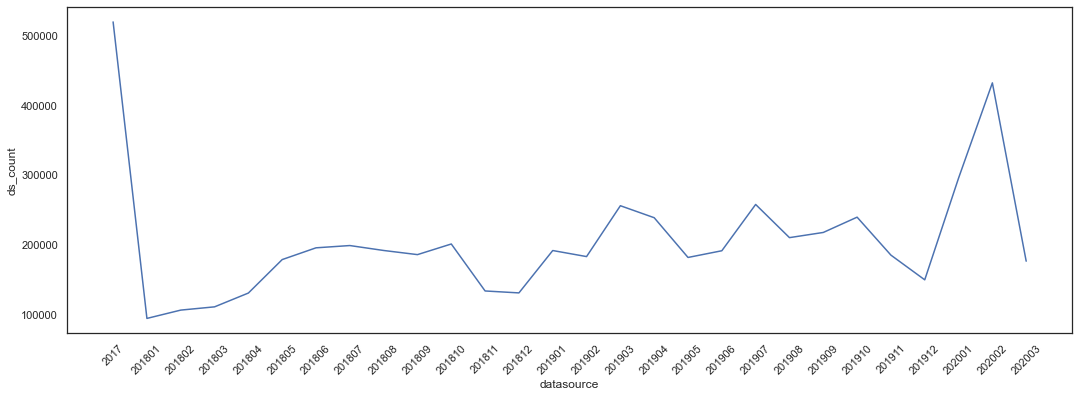

In [19]:
f = plt.figure(figsize=(18, 6))
ax = sns.lineplot(x="datasource", y="ds_count",
                  data=df_ds_counts)
plt.xticks(rotation=45);

### 1.a Add a yearmonth interval

The change from 2017 to 2018 is extreme, as we have all of the 2017 data in one block, but the other data is in terms of monthly increments.  

It would be more useful to divide data into month block based on the datetime values in the data


In [20]:
df_fordgo["yearmonth"] = (pd.DatetimeIndex(df_fordgo.start_time).year * 100) + pd.DatetimeIndex(df_fordgo.start_time).month

In [21]:
df_fordgo["yearmonth"] = df_fordgo.yearmonth.astype(str)

In [22]:
df_fordgo.yearmonth.value_counts().sort_index()

201706    2689  
201707    44073 
201708    83292 
201709    98558 
201710    108937
201711    95612 
201712    86539 
201801    94802 
201802    106718
201803    111382
201804    131169
201805    179125
201806    195968
201807    199222
201808    192162
201809    186217
201810    201458
201811    134135
201812    131363
201901    192082
201902    183412
201903    256299
201904    239111
201905    182163
201906    191772
201907    258102
201908    210563
201909    217986
201910    239895
201911    185496
201912    150102
202001    295854
202002    424789
202003    182632
202004    1732  
Name: yearmonth, dtype: int64

In [23]:
df_fordgo.loc[df_fordgo.yearmonth=="202004"].tail()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth
5795404,5795405,176792,78,2020-04-01 13:27:39,2020-04-01 13:28:58,,None,37.848477833300,-122.266081833300,,None,37.848497000000,-122.266022666700,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202004
5795405,5795406,176793,165,2020-04-01 12:53:13,2020-04-01 12:55:58,,None,37.848479500000,-122.266063166700,,None,37.848601833300,-122.265745000000,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202004
5795406,5795407,176794,61,2020-04-01 10:42:35,2020-04-01 10:43:37,,None,37.848492833300,-122.265797333300,,None,37.848475666700,-122.265779500000,999960,Subscriber,nan,None,None,app,202003,False,False,False,False,202004
5795408,5795409,176796,122,2020-04-01 13:32:28,2020-04-01 13:34:31,,None,37.848507166700,-122.266010166700,,None,37.848485500000,-122.266062833300,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202004
5795409,5795410,176797,340,2020-04-01 13:07:34,2020-04-01 13:13:14,,None,37.848530166700,-122.266013000000,,None,37.848497000000,-122.266029166700,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202004


#### Align `yearmonth` with datasource outside of 2017

In [24]:
df_fordgo.loc[(df_fordgo.datasource != "2017") & (df_fordgo.yearmonth != df_fordgo.datasource)].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth
5300811,5300812,114553,184,2020-03-01 15:59:07,2020-03-01 16:02:12,,None,37.291022333300,-121.849143833300,,None,37.294454666700,-121.852412166700,967152,Customer,nan,None,None,clipper,202002,False,False,False,False,202003
5300812,5300813,114554,167,2020-03-01 21:03:10,2020-03-01 21:05:58,,None,37.291144833300,-121.849215000000,,None,37.294452333300,-121.852453333300,967152,Customer,nan,None,None,clipper,202002,False,False,False,False,202003
5300839,5300840,114581,515,2020-03-01 16:18:04,2020-03-01 16:26:40,,None,37.293233166700,-121.881765000000,,None,37.305732833300,-121.898976333300,809335,Customer,nan,None,None,app,202002,False,False,False,False,202003
5300847,5300848,114589,222,2020-03-01 12:51:13,2020-03-01 12:54:56,,None,37.293673666700,-121.851900500000,,None,37.291026000000,-121.849130833300,967152,Customer,nan,None,None,clipper,202002,False,False,False,False,202003
5300866,5300867,114608,197,2020-03-01 16:46:45,2020-03-01 16:50:03,,None,37.294479666700,-121.852444333300,,None,37.291145500000,-121.849184166700,967152,Customer,nan,None,None,clipper,202002,False,False,False,False,202003


In [25]:
df_fordgo.loc[(df_fordgo.datasource != "2017") & 
              (df_fordgo.yearmonth != df_fordgo.datasource), ["yearmonth"]] = df_fordgo.datasource

In [26]:
df_fordgo.yearmonth.value_counts().sort_index()

201706    2689  
201707    44073 
201708    83292 
201709    98558 
201710    108937
201711    95612 
201712    86539 
201801    94802 
201802    106718
201803    111382
201804    131169
201805    179125
201806    195968
201807    199222
201808    192162
201809    186217
201810    201458
201811    134135
201812    131363
201901    192082
201902    183412
201903    256299
201904    239111
201905    182163
201906    191772
201907    258102
201908    210563
201909    217986
201910    239895
201911    185496
201912    150102
202001    295854
202002    432354
202003    176799
Name: yearmonth, dtype: int64

In [27]:
df_ds_counts = pd.DataFrame(df_fordgo.yearmonth.value_counts().sort_index().reset_index())
df_ds_counts.columns=["yearmonth", "ds_count"] 

In [28]:
df_ds_counts.head()

,yearmonth,ds_count
0,201706,2689
1,201707,44073
2,201708,83292
3,201709,98558
4,201710,108937


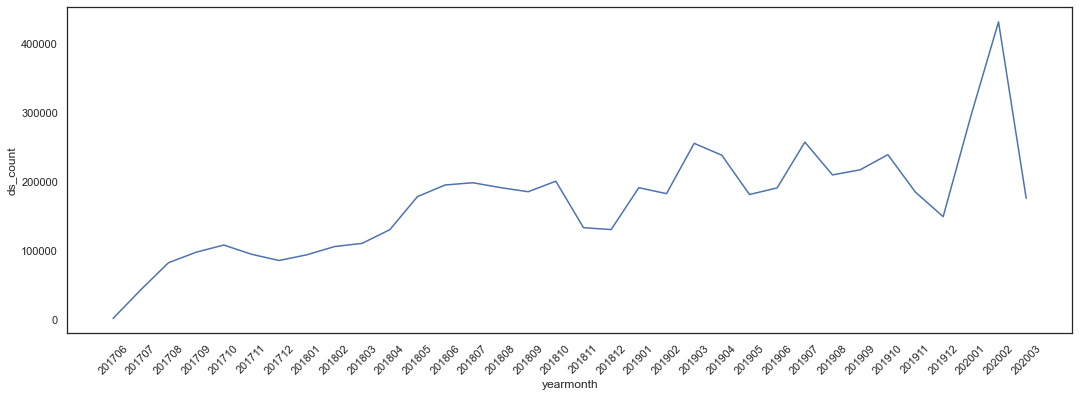

In [29]:
f = plt.figure(figsize=(18, 6))
ax = sns.lineplot(x="yearmonth", y="ds_count",
                  data=df_ds_counts)
plt.xticks(rotation=45);

----

## 2. Station IDs

In [30]:
df_start_id = df_fordgo[["start_station_id","start_station_latitude","start_station_longitude"]].groupby(
    ["start_station_id","start_station_latitude","start_station_longitude"]).count().reset_index()

In [31]:
df_start_id.head(20)

,start_station_id,start_station_latitude,start_station_longitude
0,3.000000000000,37.786375268600,-122.404904365500
1,3.000000000000,37.786375268616,-122.404904365540
2,4.000000000000,37.785880626900,-122.408915008400
3,4.000000000000,37.785880626941,-122.408915008432
4,5.000000000000,37.783899357085,-122.408444881439
5,5.000000000000,37.783899357100,-122.408444881400
6,6.000000000000,37.804770000000,-122.403234000000
7,7.000000000000,37.804562354900,-122.271738052400
8,7.000000000000,37.804562354930,-122.271738052368
9,8.000000000000,37.799953000000,-122.398525000000


In [32]:
len(df_start_id)

664

### 2.a Station latitude and longitude
- There are 664 distinct combinations of start id and latitude, longitude
- However, some are really duplicates due to rounding, some are 12 decimals, others are 10
- Therefore, reset all latitude and longitude to 10 decimals and reassess

#### Fix decimals of latitude and longitude

In [33]:
df_fordgo["start_station_latitude"] = round(df_fordgo["start_station_latitude"], 10)
df_fordgo["start_station_longitude"] = round(df_fordgo["start_station_longitude"], 10)
df_fordgo["end_station_latitude"] = round(df_fordgo["end_station_latitude"], 10)
df_fordgo["end_station_longitude"] = round(df_fordgo["end_station_longitude"], 10)

In [34]:
df_start_id = df_fordgo[["start_station_id","start_station_latitude","start_station_longitude"]].groupby(
    ["start_station_id","start_station_latitude","start_station_longitude"]).count().reset_index()

In [35]:
len(df_start_id)

524

In [36]:
df_start_id.start_station_id.value_counts()

208.000000000000    4
130.000000000000    4
408.000000000000    4
101.000000000000    3
192.000000000000    3
290.000000000000    3
229.000000000000    3
244.000000000000    3
280.000000000000    3
289.000000000000    3
277.000000000000    3
212.000000000000    3
224.000000000000    3
393.000000000000    3
182.000000000000    2
47.000000000000     2
270.000000000000    2
245.000000000000    2
37.000000000000     2
316.000000000000    2
462.000000000000    2
250.000000000000    2
349.000000000000    2
302.000000000000    2
205.000000000000    2
234.000000000000    2
131.000000000000    2
358.000000000000    2
390.000000000000    2
80.000000000000     2
344.000000000000    2
378.000000000000    2
345.000000000000    2
321.000000000000    2
16.000000000000     2
221.000000000000    2
25.000000000000     2
233.000000000000    2
377.000000000000    2
364.000000000000    2
214.000000000000    1
152.000000000000    1
200.000000000000    1
136.000000000000    1
138.000000000000    1
202.000000

#### There are some stations with more than one lat/long value...

In [37]:
df_start_id.loc[df_start_id.start_station_id.isin([208,130,408,101,47])]

,start_station_id,start_station_latitude,start_station_longitude
46,47.000000000000,37.780674771300,-122.400811314600
47,47.000000000000,37.780954599600,-122.399749159800
96,101.000000000000,37.766007742700,-122.405676841700
97,101.000000000000,37.766629000000,-122.407706000000
98,101.000000000000,37.767078504600,-122.407358586800
123,130.000000000000,37.757288407800,-122.392051219900
124,130.000000000000,37.757368990100,-122.392056584400
125,130.000000000000,37.757704041500,-122.391884923000
126,130.000000000000,37.757718421600,-122.391812503300
205,208.000000000000,37.329964000000,-121.881922000000


In [38]:
print(list(df_start_id.start_station_id.value_counts())[:41])

[4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


In [39]:
start_id_dupes = list(df_start_id.start_station_id.value_counts().index)[:40]
print(len(start_id_dupes))
print(start_id_dupes)

40
[208.0, 130.0, 408.0, 101.0, 192.0, 290.0, 229.0, 244.0, 280.0, 289.0, 277.0, 212.0, 224.0, 393.0, 182.0, 47.0, 270.0, 245.0, 37.0, 316.0, 462.0, 250.0, 349.0, 302.0, 205.0, 234.0, 131.0, 358.0, 390.0, 80.0, 344.0, 378.0, 345.0, 321.0, 16.0, 221.0, 25.0, 233.0, 377.0, 364.0]


**End Station IDs also have the same duplicates...**
- I checked that we have just 40 rows with duplicates...

In [40]:
df_end_id = df_fordgo[["end_station_id","end_station_latitude","end_station_longitude"]].groupby(
    ["end_station_id","end_station_latitude","end_station_longitude"]).count().reset_index()

In [41]:
len(df_end_id)

524

In [42]:
end_id_dupes = list(df_end_id.end_station_id.value_counts().index)[:40]
assert start_id_dupes == end_id_dupes

In [43]:
df_end_id

,end_station_id,end_station_latitude,end_station_longitude
0,3.000000000000,37.786375268600,-122.404904365500
1,4.000000000000,37.785880626900,-122.408915008400
2,5.000000000000,37.783899357100,-122.408444881400
3,6.000000000000,37.804770000000,-122.403234000000
4,7.000000000000,37.804562354900,-122.271738052400
5,8.000000000000,37.799953000000,-122.398525000000
6,9.000000000000,37.798572108500,-122.400868982100
7,10.000000000000,37.795392937300,-122.404770255100
8,11.000000000000,37.797280000000,-122.398436000000
9,12.000000000000,37.796389400000,-122.394585500000


#### Check the start and end stations align

In [44]:
df_IDs = df_start_id.merge(df_end_id, how="left", 
                           left_on=["start_station_id","start_station_latitude","start_station_longitude"],
                           right_on=["end_station_id","end_station_latitude","end_station_longitude"])

In [45]:
df_IDs.tail()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude
519,516.000000000000,37.781722000000,-122.492844000000,516.000000000000,37.781722000000,-122.492844000000
520,517.000000000000,37.786578499500,-122.453422844400,517.000000000000,37.786578499500,-122.453422844400
521,518.000000000000,37.756808000000,-122.405943000000,518.000000000000,37.756808000000,-122.405943000000
522,520.000000000000,37.781990000000,-122.482807000000,520.000000000000,37.781990000000,-122.482807000000
523,521.000000000000,37.772954000000,-122.509071000000,521.000000000000,37.772954000000,-122.509071000000


In [46]:
df_IDs.loc[df_IDs.start_station_id.isin(start_id_dupes)]

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude
13,16.000000000000,37.794130000000,-122.394430000000,16.000000000000,37.794130000000,-122.394430000000
14,16.000000000000,37.794497446000,-122.394838035100,16.000000000000,37.794497446000,-122.394838035100
23,25.000000000000,37.786928256800,-122.398113012300,25.000000000000,37.786928256800,-122.398113012300
24,25.000000000000,37.787521780500,-122.397404909100,25.000000000000,37.787521780500,-122.397404909100
35,37.000000000000,37.784999728300,-122.395935617500,37.000000000000,37.784999728300,-122.395935617500
36,37.000000000000,37.785376593800,-122.396906018300,37.000000000000,37.785376593800,-122.396906018300
46,47.000000000000,37.780674771300,-122.400811314600,47.000000000000,37.780674771300,-122.400811314600
47,47.000000000000,37.780954599600,-122.399749159800,47.000000000000,37.780954599600,-122.399749159800
77,80.000000000000,37.775234868600,-122.397437095600,80.000000000000,37.775234868600,-122.397437095600
78,80.000000000000,37.775305800000,-122.397380000000,80.000000000000,37.775305800000,-122.397380000000


**Have station IDs lat/long shifted over the years or have they always had a range?**

In [47]:
df_start_ids_with_source = df_fordgo[ 
              ["start_station_id","start_station_latitude","start_station_longitude","datasource"]].groupby(
              ["start_station_id","start_station_latitude","start_station_longitude","datasource"]).count().\
              sort_values(by=["start_station_id","datasource"]).reset_index()

### Station latitude / longitude conclusion
    
#### The lat/long changes at a point in time - assume that docks have been moved
- Therefore, changing lat/long is a non-issue

In [48]:
df_start_ids_with_source.loc[df_start_ids_with_source.start_station_id.isin(start_id_dupes)].head(50)

,start_station_id,start_station_latitude,start_station_longitude,datasource
343,16.000000000000,37.794130000000,-122.394430000000,2017
344,16.000000000000,37.794130000000,-122.394430000000,201801
345,16.000000000000,37.794130000000,-122.394430000000,201802
346,16.000000000000,37.794130000000,-122.394430000000,201803
347,16.000000000000,37.794130000000,-122.394430000000,201804
348,16.000000000000,37.794130000000,-122.394430000000,201805
349,16.000000000000,37.794130000000,-122.394430000000,201806
350,16.000000000000,37.794130000000,-122.394430000000,201807
351,16.000000000000,37.794130000000,-122.394430000000,201808
352,16.000000000000,37.794130000000,-122.394430000000,201809


----
### 2.b Station Names vs ID variability
- Station lat/long changes over time, does name also change? 

In [49]:
df_start_id_names = df_fordgo[["start_station_id","start_station_name"]].groupby(
    ["start_station_id","start_station_name"]).count().reset_index()

In [50]:
df_start_id_names.start_station_id.value_counts()

       14
321    3 
316    3 
233    3 
205    3 
221    3 
101    3 
280    3 
208    3 
349    2 
323    2 
277    2 
37     2 
212    2 
47     2 
393    2 
281    2 
50     2 
367    2 
358    2 
173    2 
234    2 
229    2 
192    2 
224    2 
364    2 
289    2 
378    2 
290    2 
272    2 
131    2 
16     2 
337    1 
488    1 
80     1 
227    1 
222    1 
189    1 
132    1 
160    1 
380    1 
288    1 
6      1 
265    1 
487    1 
302    1 
142    1 
373    1 
191    1 
270    1 
409    1 
253    1 
434    1 
498    1 
413    1 
30     1 
218    1 
437    1 
114    1 
48     1 
421    1 
187    1 
81     1 
89     1 
26     1 
395    1 
510    1 
147    1 
361    1 
204    1 
307    1 
245    1 
390    1 
166    1 
416    1 
39     1 
186    1 
52     1 
100    1 
246    1 
274    1 
462    1 
182    1 
242    1 
107    1 
181    1 
13     1 
254    1 
19     1 
249    1 
96     1 
12     1 
214    1 
102    1 
225    1 
99     1 
406    1 
198    1 
184    1 
5      1 


In [51]:
dupe_id_names = list(df_start_id_names.start_station_id.value_counts().keys())[:32]

In [52]:
df_start_ids_with_names = df_fordgo[ 
              ["start_station_id","start_station_name","datasource"]].groupby(
              ["start_station_id","start_station_name","datasource"]).count().\
              sort_values(by=["start_station_id","datasource"]).reset_index()

In [53]:
df_start_ids_with_names.loc[df_start_ids_with_names.start_station_id.isin(dupe_id_names)]

,start_station_id,start_station_name,datasource
0,,1st St at San Carlos Ave,201907
1,,2nd St at Folsom St,201907
2,,5th St at Folsom,201907
3,,5th St at Taylor St,201907
4,,Empire St at 7th St,201907
5,,Farnam St at Fruitvale Ave,201907
6,,George St at 1st St,201907
7,,Morrison Ave at Julian St,201907
8,,Jackson St at N 1st St,201911
9,,Jackson St at N 1st St,201912


### Station Names vs ID variability conclusion
- Names can also change over time - however the name does not change within a data source change

----
### 2.c Missing Station IDs
- Check alignment of missing station IDs to Stations
- Do the missing station IDs represent a data quality issue?
- Could we align these with existing stations on their latitude and longitude?

#### Create some columns that represent rounded versions of the lat/long values
- The blank start_IDs are often rounded (or truncated?) to 2 decimals

In [54]:
df_start_ids_with_source["ss_lat8round"] = round(df_start_ids_with_source.start_station_latitude, 8)
df_start_ids_with_source["ss_lat7round"] = round(df_start_ids_with_source.start_station_latitude, 7)
df_start_ids_with_source["ss_lat6round"] = round(df_start_ids_with_source.start_station_latitude, 6)
df_start_ids_with_source["ss_lat5round"] = round(df_start_ids_with_source.start_station_latitude, 5)
df_start_ids_with_source["ss_lat4round"] = round(df_start_ids_with_source.start_station_latitude, 4)
df_start_ids_with_source["ss_lat3round"] = round(df_start_ids_with_source.start_station_latitude, 3)
df_start_ids_with_source["ss_lat2round"] = round(df_start_ids_with_source.start_station_latitude, 2)

In [55]:
df_start_ids_with_source["ss_long8round"] = round(df_start_ids_with_source.start_station_longitude, 8)
df_start_ids_with_source["ss_long7round"] = round(df_start_ids_with_source.start_station_longitude, 7)
df_start_ids_with_source["ss_long6round"] = round(df_start_ids_with_source.start_station_longitude, 6)
df_start_ids_with_source["ss_long5round"] = round(df_start_ids_with_source.start_station_longitude, 5)
df_start_ids_with_source["ss_long4round"] = round(df_start_ids_with_source.start_station_longitude, 4)
df_start_ids_with_source["ss_long3round"] = round(df_start_ids_with_source.start_station_longitude, 3)
df_start_ids_with_source["ss_long2round"] = round(df_start_ids_with_source.start_station_longitude, 2)

In [56]:
df_start_ids_with_source.head()

,start_station_id,start_station_latitude,start_station_longitude,datasource,ss_lat8round,ss_lat7round,ss_lat6round,ss_lat5round,ss_lat4round,ss_lat3round,ss_lat2round,ss_long8round,ss_long7round,ss_long6round,ss_long5round,ss_long4round,ss_long3round,ss_long2round
0,3.000000000000,37.786375268600,-122.404904365500,2017,37.786375270000,37.786375300000,37.786375000000,37.786380000000,37.786400000000,37.786000000000,37.790000000000,-122.404904370000,-122.404904400000,-122.404904000000,-122.404900000000,-122.404900000000,-122.405000000000,-122.400000000000
1,3.000000000000,37.786375268600,-122.404904365500,201801,37.786375270000,37.786375300000,37.786375000000,37.786380000000,37.786400000000,37.786000000000,37.790000000000,-122.404904370000,-122.404904400000,-122.404904000000,-122.404900000000,-122.404900000000,-122.405000000000,-122.400000000000
2,3.000000000000,37.786375268600,-122.404904365500,201802,37.786375270000,37.786375300000,37.786375000000,37.786380000000,37.786400000000,37.786000000000,37.790000000000,-122.404904370000,-122.404904400000,-122.404904000000,-122.404900000000,-122.404900000000,-122.405000000000,-122.400000000000
3,3.000000000000,37.786375268600,-122.404904365500,201803,37.786375270000,37.786375300000,37.786375000000,37.786380000000,37.786400000000,37.786000000000,37.790000000000,-122.404904370000,-122.404904400000,-122.404904000000,-122.404900000000,-122.404900000000,-122.405000000000,-122.400000000000
4,3.000000000000,37.786375268600,-122.404904365500,201804,37.786375270000,37.786375300000,37.786375000000,37.786380000000,37.786400000000,37.786000000000,37.790000000000,-122.404904370000,-122.404904400000,-122.404904000000,-122.404900000000,-122.404900000000,-122.405000000000,-122.400000000000


#### See how those with blank start station IDs map to this set of potential fixes

In [57]:
df_start_id_nans.head(2)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,datasource,recid
1143064,nan,None,37.400000000000,-121.940000000000,201806,1143065
1143076,nan,None,37.400000000000,-121.940000000000,201806,1143077


In [58]:
df_start_id_nans_unique = df_start_id_nans[["start_station_latitude","start_station_longitude","datasource"]].groupby(
              ["start_station_latitude","start_station_longitude","datasource"]).count().\
              sort_values(by=["start_station_latitude","start_station_longitude","datasource"]).reset_index()

In [59]:
len(df_start_id_nans),len(df_start_id_nans_unique)

(578807, 566576)

In [60]:
df_start_id_nans_unique.head()

,start_station_latitude,start_station_longitude,datasource
0,36.163261166700,-86.775811666700,201911
1,36.163307000000,-86.775634166700,201911
2,36.163310833300,-86.776017666700,201911
3,36.163449000000,-86.775768500000,201911
4,36.163580000000,-86.775177166700,201911


In [61]:
df_start_id_nans_fullmatched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["start_station_latitude","start_station_longitude","datasource"])

In [62]:
len(df_start_id_nans_fullmatched)

0

In [63]:
df_start_id_nans_round8matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat8round","ss_long8round","datasource"])

In [64]:
len(df_start_id_nans_round8matched)

0

In [65]:
df_start_id_nans_round7matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat7round","ss_long7round","datasource"])

In [66]:
len(df_start_id_nans_round7matched)

0

In [67]:
df_start_id_nans_round6matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat6round","ss_long6round","datasource"])

In [68]:
len(df_start_id_nans_round6matched)

0

In [69]:
df_start_id_nans_round5matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat5round","ss_long5round","datasource"])

In [70]:
len(df_start_id_nans_round5matched)

0

In [71]:
df_start_id_nans_round4matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat4round","ss_long4round","datasource"])

In [72]:
len(df_start_id_nans_round4matched)

0

In [73]:
df_start_id_nans_round3matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat3round","ss_long3round","datasource"])

In [74]:
len(df_start_id_nans_round3matched)

0

In [75]:
df_start_id_nans_round2matched = df_start_id_nans_unique.merge(df_start_ids_with_source, 
                           how="inner", 
                           left_on=["start_station_latitude","start_station_longitude","datasource"],
                           right_on=["ss_lat2round","ss_long2round","datasource"])

In [76]:
len(df_start_id_nans_round2matched)

102

In [77]:
df_start_id_nans_round2matched[["start_station_latitude_x","start_station_longitude_x","datasource","start_station_id",
                                "start_station_latitude_y","start_station_longitude_y","ss_lat2round","ss_long2round"]]

,start_station_latitude_x,start_station_longitude_x,datasource,start_station_id,start_station_latitude_y,start_station_longitude_y,ss_lat2round,ss_long2round
0,37.330000000000,-121.910000000000,201806,276.000000000000,37.332232600000,-121.912516500000,37.330000000000,-121.910000000000
1,37.330000000000,-121.910000000000,201806,277.000000000000,37.333657700000,-121.908585900000,37.330000000000,-121.910000000000
2,37.330000000000,-121.910000000000,201807,276.000000000000,37.332232600000,-121.912516500000,37.330000000000,-121.910000000000
3,37.330000000000,-121.910000000000,201807,277.000000000000,37.333657700000,-121.908585900000,37.330000000000,-121.910000000000
4,37.330000000000,-121.910000000000,201811,276.000000000000,37.332232600000,-121.912516500000,37.330000000000,-121.910000000000
5,37.330000000000,-121.910000000000,201811,277.000000000000,37.333657700000,-121.908585900000,37.330000000000,-121.910000000000
6,37.330000000000,-121.900000000000,201806,35.000000000000,37.329118668100,-121.904575824700,37.330000000000,-121.900000000000
7,37.330000000000,-121.900000000000,201806,278.000000000000,37.331932300000,-121.904888200000,37.330000000000,-121.900000000000
8,37.330000000000,-121.900000000000,201806,283.000000000000,37.330264100000,-121.897701800000,37.330000000000,-121.900000000000
9,37.330000000000,-121.900000000000,201806,307.000000000000,37.332692000000,-121.900084000000,37.330000000000,-121.900000000000


### Missing Station IDs conclusion
- There is no alignment with exisiting stations unless we round to 2 decimals
- Therefore, there is little justification for trying to fix blank station IDs
- Reading about the Ford GoBike / Lyft Bay Wheels service reveals that some bikes are dockless and secured only with locks
- Which supports the insight that blank station IDs are valid

In [78]:
del df_start_ids_with_source
del df_start_id_nans
del df_start_id_nans_unique
del df_start_id_nans_fullmatched
del df_start_id_nans_round8matched
del df_start_id_nans_round7matched
del df_start_id_nans_round6matched
del df_start_id_nans_round5matched
del df_start_id_nans_round4matched
del df_start_id_nans_round3matched
del df_start_id_nans_round2matched

### 2.d Convert Station ID to character
- Add columns to help process blank Station IDs

In [79]:
df_fordgo["start_station_id"] = df_fordgo.start_station_id.astype(str).replace('\.0', '', regex=True)
df_fordgo["end_station_id"] = df_fordgo.end_station_id.astype(str).replace('\.0', '', regex=True)

In [80]:
df_fordgo.loc[df_fordgo.start_station_id=="nan"].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource
1143064,1143065,168,5572,2018-06-30 20:58:31.855,2018-06-30 22:31:24.593,nan,None,37.400000000000,-121.940000000000,nan,None,37.400000000000,-121.940000000000,4202,Customer,1989.000000000000,Male,No,None,201806
1143076,1143077,180,573,2018-06-30 22:12:27.511,2018-06-30 22:22:01.174,nan,None,37.400000000000,-121.940000000000,nan,None,37.400000000000,-121.930000000000,4095,Subscriber,1994.000000000000,Male,Yes,None,201806
1143093,1143094,197,850,2018-06-30 22:01:25.585,2018-06-30 22:15:36.151,nan,None,37.410000000000,-121.940000000000,nan,None,37.410000000000,-121.950000000000,4122,Customer,1990.000000000000,Male,No,None,201806
1143129,1143130,233,562,2018-06-30 21:52:05.118,2018-06-30 22:01:27.440,nan,None,37.410000000000,-121.940000000000,nan,None,37.420000000000,-121.940000000000,4184,Subscriber,1989.000000000000,Male,No,None,201806
1143156,1143157,260,819,2018-06-30 21:37:34.506,2018-06-30 21:51:13.729,nan,None,37.410000000000,-121.940000000000,nan,None,37.410000000000,-121.960000000000,4137,Customer,1985.000000000000,Male,No,None,201806


In [81]:
df_fordgo["has_start_id"] = True
df_fordgo["has_end_id"] = True

In [82]:
%%time
df_fordgo.loc[df_fordgo.start_station_id=="nan", ["has_start_id"]] = False
df_fordgo.loc[df_fordgo.end_station_id=="nan", ["has_end_id"]] = False

In [83]:
%%time
df_fordgo.loc[df_fordgo.has_start_id == False, ["start_station_id"]] = ""
df_fordgo.loc[df_fordgo.has_end_id == False, ["end_station_id"]] = ""

Wall time: 2min


In [84]:
df_fordgo.loc[df_fordgo.has_start_id == False].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id
1143064,1143065,168,5572,2018-06-30 20:58:31.855,2018-06-30 22:31:24.593,,None,37.400000000000,-121.940000000000,,None,37.400000000000,-121.940000000000,4202,Customer,1989.000000000000,Male,No,None,201806,False,False
1143076,1143077,180,573,2018-06-30 22:12:27.511,2018-06-30 22:22:01.174,,None,37.400000000000,-121.940000000000,,None,37.400000000000,-121.930000000000,4095,Subscriber,1994.000000000000,Male,Yes,None,201806,False,False
1143093,1143094,197,850,2018-06-30 22:01:25.585,2018-06-30 22:15:36.151,,None,37.410000000000,-121.940000000000,,None,37.410000000000,-121.950000000000,4122,Customer,1990.000000000000,Male,No,None,201806,False,False
1143129,1143130,233,562,2018-06-30 21:52:05.118,2018-06-30 22:01:27.440,,None,37.410000000000,-121.940000000000,,None,37.420000000000,-121.940000000000,4184,Subscriber,1989.000000000000,Male,No,None,201806,False,False
1143156,1143157,260,819,2018-06-30 21:37:34.506,2018-06-30 21:51:13.729,,None,37.410000000000,-121.940000000000,,None,37.410000000000,-121.960000000000,4137,Customer,1985.000000000000,Male,No,None,201806,False,False


In [85]:
df_fordgo["has_start_name"] = True
df_fordgo["has_end_name"] = True

In [86]:
%%time
df_fordgo.loc[df_fordgo.start_station_name.isna(), ["has_start_name"]] = False
df_fordgo.loc[df_fordgo.end_station_name.isna(), ["has_end_name"]] = False

Wall time: 2min 8s


In [87]:
df_fordgo.loc[df_fordgo.has_start_name == False].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name
1143064,1143065,168,5572,2018-06-30 20:58:31.855,2018-06-30 22:31:24.593,,None,37.400000000000,-121.940000000000,,None,37.400000000000,-121.940000000000,4202,Customer,1989.000000000000,Male,No,None,201806,False,False,False,False
1143076,1143077,180,573,2018-06-30 22:12:27.511,2018-06-30 22:22:01.174,,None,37.400000000000,-121.940000000000,,None,37.400000000000,-121.930000000000,4095,Subscriber,1994.000000000000,Male,Yes,None,201806,False,False,False,False
1143093,1143094,197,850,2018-06-30 22:01:25.585,2018-06-30 22:15:36.151,,None,37.410000000000,-121.940000000000,,None,37.410000000000,-121.950000000000,4122,Customer,1990.000000000000,Male,No,None,201806,False,False,False,False
1143129,1143130,233,562,2018-06-30 21:52:05.118,2018-06-30 22:01:27.440,,None,37.410000000000,-121.940000000000,,None,37.420000000000,-121.940000000000,4184,Subscriber,1989.000000000000,Male,No,None,201806,False,False,False,False
1143156,1143157,260,819,2018-06-30 21:37:34.506,2018-06-30 21:51:13.729,,None,37.410000000000,-121.940000000000,,None,37.410000000000,-121.960000000000,4137,Customer,1985.000000000000,Male,No,None,201806,False,False,False,False


----

## 3. Stations to ride counts distributions

In [88]:
df_fordgo.start_station_id.value_counts()

       578807
58     99612 
15     97387 
30     95304 
81     94194 
67     86248 
21     83990 
3      80965 
6      78371 
16     75154 
22     73095 
5      68187 
17     54924 
66     53974 
50     52032 
90     48065 
44     46498 
27     46093 
93     45374 
23     43525 
19     40011 
182    39435 
243    37375 
61     35777 
24     34446 
114    34403 
20     33379 
43     32572 
324    31928 
28     31644 
60     31545 
176    31454 
239    31399 
126    31159 
37     30905 
104    30836 
98     30759 
134    30343 
59     29895 
321    29836 
80     29755 
89     29203 
36     28459 
14     28226 
70     28053 
245    27775 
25     27687 
74     27678 
284    27265 
109    27258 
8      27184 
11     26664 
47     26658 
350    26170 
343    26168 
9      26012 
41     25831 
223    25831 
323    25698 
49     25636 
86     24929 
121    24897 
130    24434 
77     24377 
163    24291 
13     23449 
160    23244 
7      23161 
75     23108 
78     22995 
88     22935 
62    

#### Any easily visible commonality to the geographical coordinates of the most popular stations?

In [89]:
df_fordgo.loc[df_fordgo.start_station_id.isin(list(df_fordgo.start_station_id.value_counts().keys())[1:11]),
             ["start_station_id","start_station_latitude","start_station_longitude"]].head()

,start_station_id,start_station_latitude,start_station_longitude
5,30,37.776598000000,-122.395282000000
12,67,37.776639200000,-122.395526300000
13,67,37.776639200000,-122.395526300000
21,30,37.776598000000,-122.395282000000
27,6,37.804770000000,-122.403234000000


### An Excel spreadsheet of the groupings of counts of Start Stations per latitude and longitude

![start_station_distributions](images/Start_Station_Distributions.PNG)

----
### There are 3 groups...

#### From latitude 37.71 to 37.8 and longitude -122.5 to -122.37
![Start_Station_Detail_1](images/Start_Station_Detail_1xxx.PNG)

#### From latitude 37.77 to 37.88 and longitude -122.29 to -122.21
![Start_Station_Detail_2](images/Start_Station_Detail_2xxx.PNG)

#### From latitude 37.26 to 37.37 and longitude -121.92 to -121.83

![Start_Station_Detail_3](images/Start_Station_Detail_3xxx.PNG)

#### There are some outliers
- There are some entries with no latitude and longitude, for Start Stations "16th Depot Bike Fleet Station" and "SF Test Station"
<br>   
![Start_Station_Outliers](images/Start_Station_Outliers.PNG)

In [90]:
pd.DataFrame(df_fordgo.loc[(df_fordgo.has_start_id) & 
                           ((df_fordgo.start_station_latitude == 0) |
                            (df_fordgo.start_station_latitude > 39)),
              ["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]].\
              groupby(["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]).\
              size().reset_index().rename(columns={0:"idcount"}))

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,idcount
0,408,MTL-ECO5-01,45.510000000000,-73.570000000000,4
1,420,SF Test Station,0.000000000000,0.000000000000,1
2,449,16th Depot Bike Fleet Station,0.000000000000,0.000000000000,35
3,484,Philly Demo,39.892567097100,-75.173714160900,2


### The equivalent for those where no Start Station is given (dockless bikes?)

#### Showing the entire plot, including outliers 

![Missing_Start_Distributions](images/Missing_Start_Distributions.PNG)

#### The outliers
- a longitude > -94...  

![Missing_Start_Outliers](images/Missing_Start_Outliers.PNG)

In [91]:
pd.DataFrame(df_fordgo.loc[(df_fordgo.has_start_id==False) & 
                           (df_fordgo.start_station_longitude > -94), 
              ["start_station_latitude","start_station_longitude"]].\
              groupby( ["start_station_latitude","start_station_longitude"]).\
              size().reset_index().rename(columns={0:"idcount"})).\
              sort_values(by="idcount", ascending=False).reset_index(drop=True)

,start_station_latitude,start_station_longitude,idcount
0,45.510000000000,-73.570000000000,4
1,40.660000000000,-74.010000000000,3
2,44.950000000000,-93.220000000000,2
3,45.500000000000,-73.570000000000,2
4,36.163261166700,-86.775811666700,1
5,36.163307000000,-86.775634166700,1
6,36.163310833300,-86.776017666700,1
7,36.163449000000,-86.775768500000,1
8,36.163580000000,-86.775177166700,1


#### All the outliers
- Any with a longitude > -94

In [92]:
pd.DataFrame(df_fordgo.loc[(df_fordgo.start_station_longitude > -94), 
              ["start_station_latitude","start_station_longitude"]].\
              groupby( ["start_station_latitude","start_station_longitude"]).\
              size().reset_index().rename(columns={0:"idcount"})).\
              sort_values(by="start_station_longitude").reset_index(drop=True)

,start_station_latitude,start_station_longitude,idcount
0,44.950000000000,-93.220000000000,2
1,36.163310833300,-86.776017666700,1
2,36.163261166700,-86.775811666700,1
3,36.163449000000,-86.775768500000,1
4,36.163307000000,-86.775634166700,1
5,36.163580000000,-86.775177166700,1
6,39.892567097100,-75.173714160900,2
7,40.660000000000,-74.010000000000,3
8,45.500000000000,-73.570000000000,2
9,45.510000000000,-73.570000000000,8


#### Save the longitude outliers

In [93]:
df_fordgo.loc[df_fordgo.start_station_longitude > -94].to_pickle("fordgo_longitude_outliers.pkl")

#### There are some entries without Start Station ID, but have Station Names

In [94]:
pd.DataFrame(df_fordgo.loc[(df_fordgo.has_start_id==False) & (df_fordgo.has_start_name),
              ["start_station_id", "start_station_name"]].\
              groupby(["start_station_id", "start_station_name"]).\
              size().reset_index().rename(columns={0:"idcount"})).\
              sort_values(by="idcount", ascending=False).reset_index(drop=True)

,start_station_id,start_station_name,idcount
0,,Steuart St at Market St,580
1,,4th St at Harrison St,304
2,,Broadway at Kearny,171
3,,2nd St at Folsom St,161
4,,5th St at Folsom,154
5,,Morrison Ave at Julian St,122
6,,Green St at Van Ness St,116
7,,1st St at San Carlos Ave,72
8,,Clement St at 32nd Avenue,62
9,,George St at 1st St,46


#### From latitude 37.7 to 37.81 and longitude -122.51 to -122.36
![Missing_Start_Detail_1](images/Missing_Start_Detail_1.PNG)

#### From latitude 37.73 to 37.89 and longitude -122.33 to -122.15
![Missing_Start_Detail_2](images/Missing_Start_Detail_2.PNG)

#### From latitude 37.16 to 37.45 and longitude -122.99 to -86.77
![Missing_Start_Detail_3](images/Missing_Start_Detail_3xx.PNG)

### Assemble a summary dataset of Start Station counts per rounded latitude and longitude

In [95]:
df_latlong_start_station_counts = pd.DataFrame(df_fordgo[
    ["start_station_latitude","start_station_longitude","has_start_id"]].groupby(
    ["start_station_latitude","start_station_longitude","has_start_id"]).size().sort_values(ascending=False).reset_index())

df_latlong_start_station_counts.columns=["start_station_latitude","start_station_longitude","has_start_id","idcount"]

In [96]:
df_latlong_start_station_counts.head()

,start_station_latitude,start_station_longitude,has_start_id,idcount
0,37.776619000000,-122.417385000000,True,99612
1,37.795392000000,-122.394203000000,True,97387
2,37.776598000000,-122.395282000000,True,95304
3,37.775880000000,-122.393170000000,True,94194
4,37.776639200000,-122.395526300000,True,86248


In [97]:
df_latlong_start_station_counts.loc[df_latlong_start_station_counts.has_start_id==False].head()

,start_station_latitude,start_station_longitude,has_start_id,idcount
338,37.410000000000,-121.940000000000,False,2204
355,37.400000000000,-121.940000000000,False,1686
358,37.400000000000,-121.930000000000,False,1545
363,37.410000000000,-121.960000000000,False,1353
371,37.400000000000,-121.920000000000,False,1191


In [98]:
df_latlong_start_station_counts.loc[
    (round(df_latlong_start_station_counts.start_station_latitude, 2) == 37.76) &
    (round(df_latlong_start_station_counts.start_station_longitude, 2) == -122.42)].head()

,start_station_latitude,start_station_longitude,has_start_id,idcount
43,37.763315800000,-122.421903900000,True,27258
51,37.764765215500,-122.420091033000,True,25831
56,37.759210300000,-122.421339200000,True,24897
76,37.755212600000,-122.420975200000,True,20670
79,37.756708300000,-122.421025000000,True,20433


In [99]:
df_latlong_start_station_counts.loc[
    (round(df_latlong_start_station_counts.start_station_latitude, 2) == 37.76) &
    (round(df_latlong_start_station_counts.start_station_longitude, 2) == -122.42),["idcount"]].sum()

idcount    180335
dtype: int64

In [100]:
df_latlong_start_station_counts["start_station_latitude_rnd"] = \
    round(df_latlong_start_station_counts.start_station_latitude, 2)
df_latlong_start_station_counts["start_station_longitude_rnd"] = \
    round(df_latlong_start_station_counts.start_station_longitude, 2)

In [101]:
df_latlong_start_station_counts.loc[
    (df_latlong_start_station_counts.start_station_latitude_rnd == 37.76) &
    (df_latlong_start_station_counts.start_station_longitude_rnd == -122.42),["idcount"]].sum()

idcount    180335
dtype: int64

In [102]:
df_latlong_start_station_counts.to_pickle("df_latlong_start_station_counts.pkl")

In [103]:
if Path("df_latlong_start_station_counts.pkl").is_file():
    df_latlong_start_station_counts = pd.read_pickle("df_latlong_start_station_counts.pkl")

In [104]:
df_latlong_start_id_summary = pd.DataFrame(df_latlong_start_station_counts[
                    ["start_station_latitude_rnd","start_station_longitude_rnd","has_start_id","idcount"]].groupby(
                    ["start_station_latitude_rnd","start_station_longitude_rnd","has_start_id"]).sum().sort_values(
                    by="idcount", ascending=False).reset_index())

df_latlong_start_id_summary.columns=["start_station_latitude","start_station_longitude","has_start_id","latlongcount"]

In [105]:
df_latlong_start_id_summary.head(10)

,start_station_latitude,start_station_longitude,has_start_id,latlongcount
0,37.790000000000,-122.400000000000,True,378660
1,37.780000000000,-122.400000000000,True,377873
2,37.790000000000,-122.390000000000,True,322238
3,37.780000000000,-122.390000000000,True,274858
4,37.780000000000,-122.410000000000,True,213430
5,37.800000000000,-122.400000000000,True,212505
6,37.780000000000,-122.420000000000,True,195641
7,37.770000000000,-122.420000000000,True,189626
8,37.770000000000,-122.410000000000,True,166375
9,37.760000000000,-122.420000000000,True,162418


In [106]:
df_latlong_start_id_summary.loc[
    (df_latlong_start_id_summary.start_station_latitude == 37.76) &
    (df_latlong_start_id_summary.start_station_longitude == -122.42),["has_start_id","latlongcount"]]

,has_start_id,latlongcount
9,True,162418
61,False,17917


### Remove the outliers

In [107]:
df_latlong_start_id_summary.loc[
    (df_latlong_start_id_summary.start_station_latitude == 0) &
    (df_latlong_start_id_summary.start_station_longitude == 0),["has_start_id","latlongcount"]]

,has_start_id,latlongcount
405,True,36


In [108]:
df_latlong_start_id_summary = df_latlong_start_id_summary.loc[~(
    (df_latlong_start_id_summary.start_station_latitude == 0) &
    (df_latlong_start_id_summary.start_station_longitude == 0))]

In [109]:
df_latlong_start_id_summary.loc[
    (df_latlong_start_id_summary.start_station_latitude == 0) &
    (df_latlong_start_id_summary.start_station_longitude == 0),["latlongcount"]]

,latlongcount


### Scatterplot the latitude and longitude, using trip sum as size

In [110]:
sns.set(style="white")

#### All data

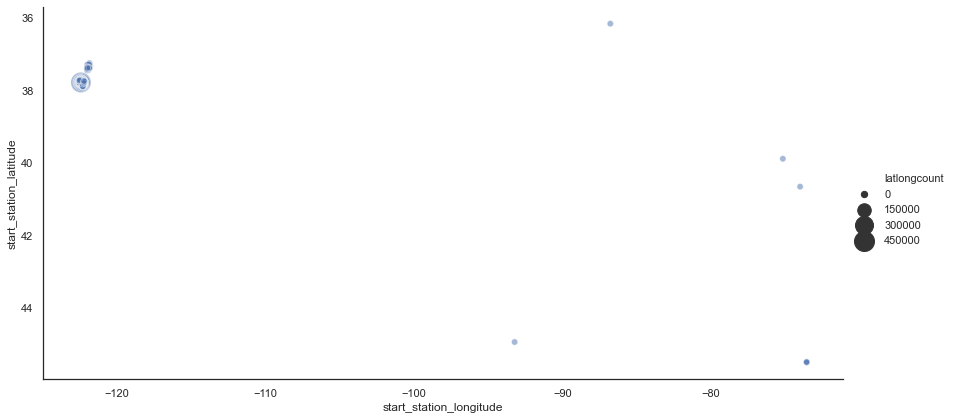

In [111]:
sns.relplot(x="start_station_longitude", y="start_station_latitude", size="latlongcount",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, aspect=2,
            data=df_latlong_start_id_summary)

plt.gca().invert_yaxis();

#### Only those with Start Station IDs

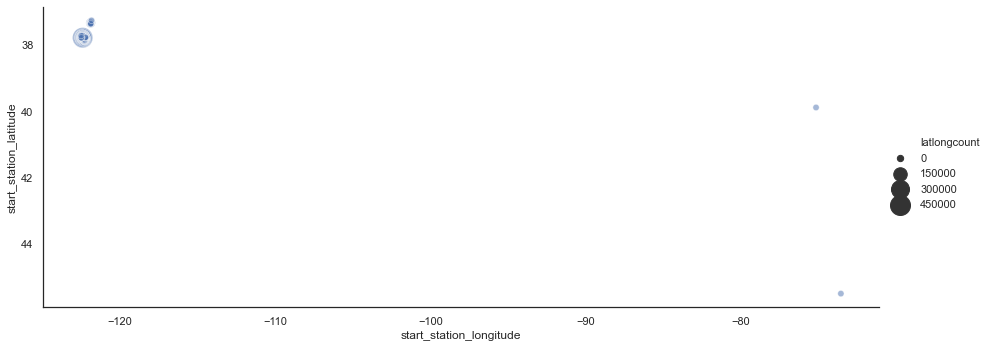

In [112]:
sns.relplot(x="start_station_longitude", y="start_station_latitude", size="latlongcount",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=5, aspect=2.5,
            data=df_latlong_start_id_summary.loc[df_latlong_start_id_summary.has_start_id])

plt.gca().invert_yaxis();

#### Only those with Start Station IDs and excluding the outliers

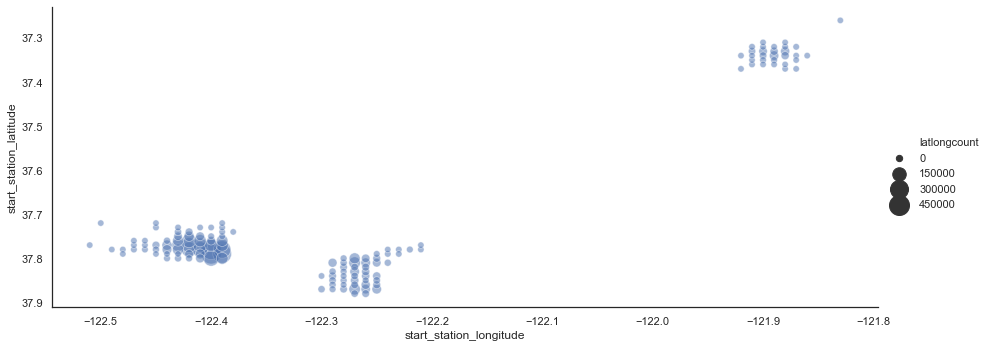

In [113]:
sns.relplot(x="start_station_longitude", y="start_station_latitude", size="latlongcount",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=5, aspect=2.5,
            data=df_latlong_start_id_summary.loc[
                (df_latlong_start_id_summary.has_start_id) &
                (df_latlong_start_id_summary.start_station_longitude < -94)])

plt.gca().invert_yaxis();

#### Only those with NO Start Station IDs and excluding the outliers

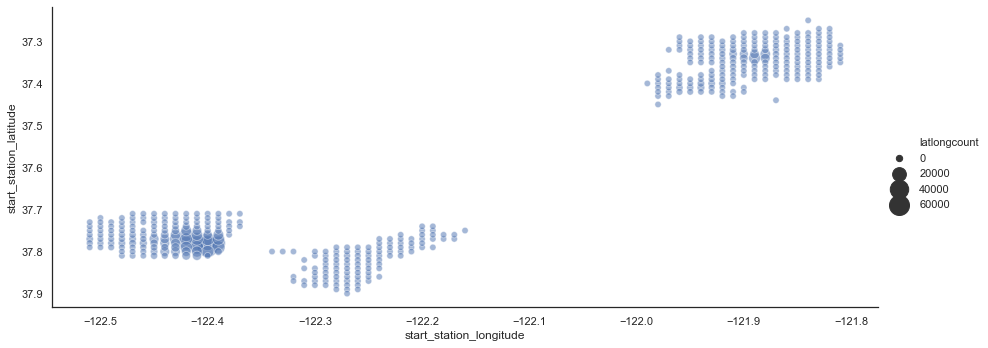

In [114]:
sns.relplot(x="start_station_longitude", y="start_station_latitude", size="latlongcount",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=5, aspect=2.5,
            data=df_latlong_start_id_summary.loc[
                (df_latlong_start_id_summary.has_start_id==False) &
                (df_latlong_start_id_summary.start_station_longitude < -94)])

plt.gca().invert_yaxis();

#### All data but without outliers

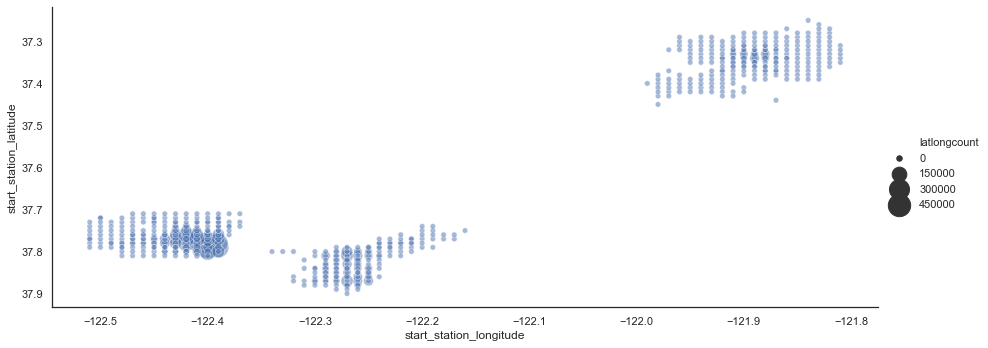

In [115]:
sns.relplot(x="start_station_longitude", y="start_station_latitude", size="latlongcount",
            sizes=(30, 500), alpha=.5, palette="muted",
            height=5, aspect=2.5,
            data=df_latlong_start_id_summary.loc[
                (df_latlong_start_id_summary.start_station_longitude < -94)])

plt.gca().invert_yaxis();

#### Compared to the plot of all points in Excel
- minus the outliers

![All_no_outliers](images/All_no_outliers.PNG)

In [116]:
df_latlong_start_id_summary.to_pickle("df_latlong_start_id_summary.pkl")

In [117]:
if Path("df_latlong_start_id_summary.pkl").is_file():
    df_latlong_start_id_summary = pd.read_pickle("df_latlong_start_id_summary.pkl")

### Conclusion of stations to ride counts distributions
- There are 3 groups of latitude and longitude
- These should be mapped geographically to gain an understanding
- Not all lat/long coordinates belong to Station IDs, these are likely more fluid in their locations
- There are some outliers which we can exclude if required through a simple filter on longitude >= -94  

----

## 4. Gender
- `member_gender`

In [118]:
df_fordgo.member_gender.value_counts()

Male      2251128
Female    735690 
Other     49774  
Name: member_gender, dtype: int64

In [119]:
df_fordgo.loc[df_fordgo.member_gender.notna()].yearmonth.value_counts().sort_index()

201706    2387  
201707    35910 
201708    69783 
201709    85437 
201710    95336 
201711    86129 
201712    78256 
201801    87001 
201802    98662 
201803    102385
201804    121827
201805    167413
201806    183402
201807    186832
201808    181287
201809    176338
201810    192818
201811    129037
201812    126352
201901    182365
201902    175147
201903    244576
201904    227912
Name: yearmonth, dtype: int64

In [120]:
df_gender_unique = df_fordgo[["yearmonth", "member_gender"]].groupby(
              ["yearmonth", "member_gender"]).size().reset_index()

df_gender_unique.columns=["yearmonth", "member_gender","idcount"]

In [121]:
df_gender_unique.head(9)

,yearmonth,member_gender,idcount
0,201706,Female,374
1,201706,Male,2000
2,201706,Other,13
3,201707,Female,7483
4,201707,Male,28100
5,201707,Other,327
6,201708,Female,14787
7,201708,Male,54256
8,201708,Other,740


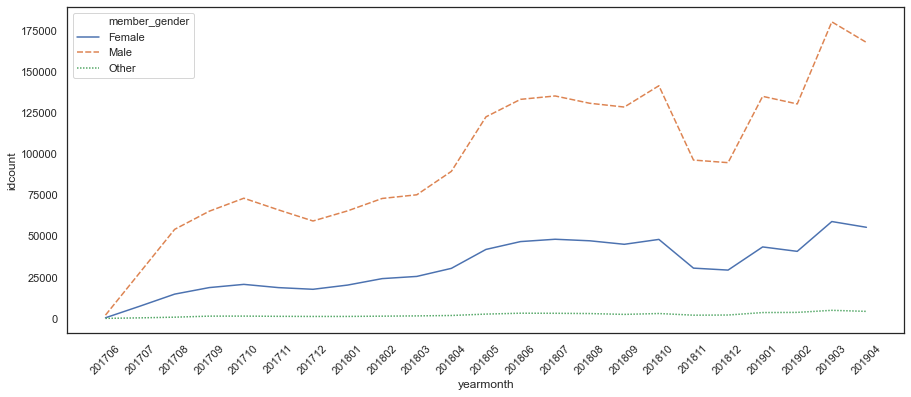

In [122]:
f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="yearmonth", y="idcount",
                  hue="member_gender", 
                  style="member_gender", 
                  data=df_gender_unique)
plt.xticks(rotation=45);

### Gender Conclusions
- Gender data does not exist beyond April 2014...
- Male users outnumber females by two to three times
- Gender "Other" is very much smaller than the other genders, and may present issues with comparative charts...

----

## 5. Year of Birth
- `member_birth_year`
- examine for any outliers
- create an age value as a more useful point in the data

In [123]:
df_fordgo.member_birth_year.min(), df_fordgo.member_birth_year.max()

(1878.0, 2001.0)

In [124]:
df_fordgo["member_birth_year"].value_counts().sort_index()

1878.000000000000    7     
1881.000000000000    5     
1886.000000000000    3     
1888.000000000000    23    
1889.000000000000    3     
1896.000000000000    35    
1900.000000000000    997   
1901.000000000000    77    
1902.000000000000    436   
1903.000000000000    1     
1904.000000000000    18    
1906.000000000000    2     
1907.000000000000    7     
1909.000000000000    4     
1910.000000000000    1     
1911.000000000000    276   
1914.000000000000    18    
1920.000000000000    116   
1923.000000000000    6     
1924.000000000000    200   
1927.000000000000    21    
1928.000000000000    50    
1930.000000000000    2     
1931.000000000000    542   
1932.000000000000    36    
1933.000000000000    349   
1934.000000000000    111   
1935.000000000000    314   
1936.000000000000    305   
1938.000000000000    79    
1939.000000000000    104   
1940.000000000000    70    
1941.000000000000    229   
1942.000000000000    561   
1943.000000000000    797   
1944.000000000000   

### Birth year issues

#### Birth years earlier than 1917 seem unlikely
- It would mean that the bike hirer would be over 100 years old in 2017 when the data begins

In [125]:
df_fordgo.loc[df_fordgo.member_birth_year < 1917]["member_birth_year"].value_counts().sort_index()

1878.000000000000    7  
1881.000000000000    5  
1886.000000000000    3  
1888.000000000000    23 
1889.000000000000    3  
1896.000000000000    35 
1900.000000000000    997
1901.000000000000    77 
1902.000000000000    436
1903.000000000000    1  
1904.000000000000    18 
1906.000000000000    2  
1907.000000000000    7  
1909.000000000000    4  
1910.000000000000    1  
1911.000000000000    276
1914.000000000000    18 
Name: member_birth_year, dtype: int64

In [126]:
df_fordgo.loc[df_fordgo.member_birth_year < 1900].head()

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth
425817,425818,425817,2546,2017-08-19 17:47:32.110,2017-08-19 18:29:58.825,197,El Embarcadero at Grand Ave,37.808847900000,-122.249679900000,172,College Ave at Taft Ave,37.841799900000,-122.251534900000,1448,Customer,1886.000000000000,Male,None,None,2017,True,True,True,True,201708
426608,426609,426608,1767,2017-08-19 13:20:02.170,2017-08-19 13:49:29.735,235,Union St at 10th St,37.807239300000,-122.289370200000,197,El Embarcadero at Grand Ave,37.808847900000,-122.249679900000,91,Customer,1886.000000000000,Male,None,None,2017,True,True,True,True,201708
1068317,1068318,104546,749,2018-05-14 06:46:47.550,2018-05-14 06:59:16.657,28,The Embarcadero at Bryant St,37.787168014700,-122.388097923300,81,Berry St at 4th St,37.775880000000,-122.393170000000,630,Subscriber,1889.000000000000,Male,No,None,201805,True,True,True,True,201805
1082205,1082206,118434,654,2018-05-11 06:48:36.910,2018-05-11 06:59:31.647,28,The Embarcadero at Bryant St,37.787168014700,-122.388097923300,81,Berry St at 4th St,37.775880000000,-122.393170000000,1593,Subscriber,1889.000000000000,Male,No,None,201805,True,True,True,True,201805
1087568,1087569,123797,546,2018-05-10 10:49:26.472,2018-05-10 10:58:32.579,81,Berry St at 4th St,37.775880000000,-122.393170000000,81,Berry St at 4th St,37.775880000000,-122.393170000000,1524,Subscriber,1889.000000000000,Male,No,None,201805,True,True,True,True,201805


In [127]:
df_birth_years = df_fordgo[["yearmonth", "member_birth_year"]].groupby(
              ["yearmonth", "member_birth_year"]).size().reset_index()

df_birth_years.columns=["yearmonth", "member_birth_year","idcount"]

In [128]:
df_birth_years["member_age"] = df_birth_years.yearmonth.astype(int) // 100 - df_birth_years.member_birth_year

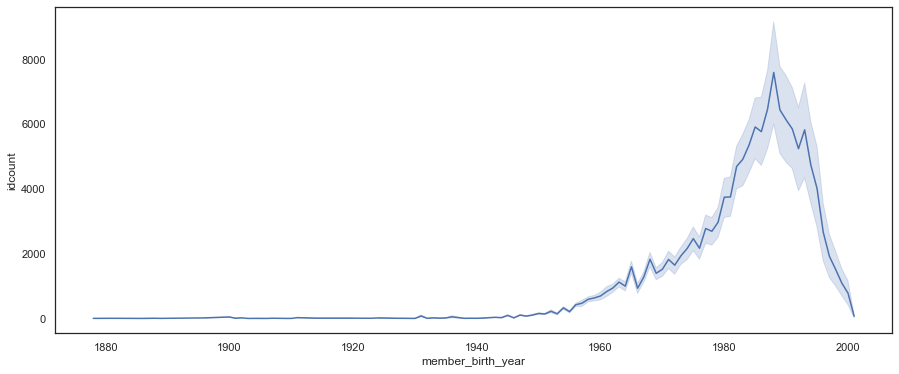

In [129]:
f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="member_birth_year", y="idcount",
                  data=df_birth_years);

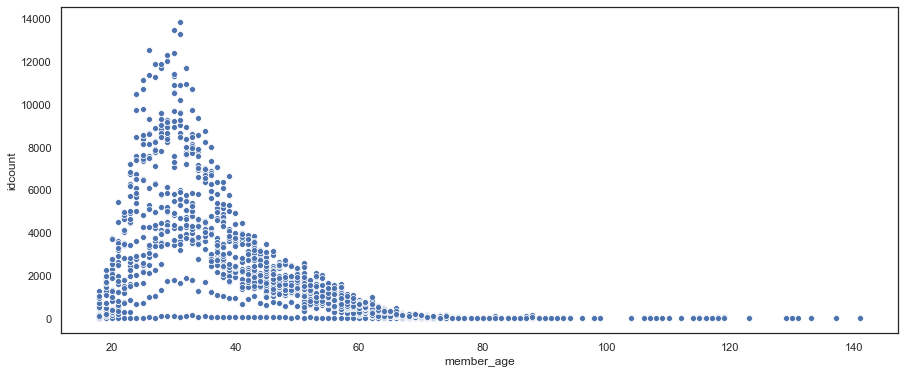

In [130]:
f = plt.figure(figsize=(15, 6))
ax = sns.scatterplot(x="member_age", y="idcount",
                  data=df_birth_years);

#### Assume keying entry for birth year < 1900
- It would be easy to hit an 8 instead of a 9, so remove 100 from the age of those entries

In [131]:
df_birth_years.loc[df_birth_years.member_birth_year < 1900, ["member_age"]] = df_birth_years.member_age - 100

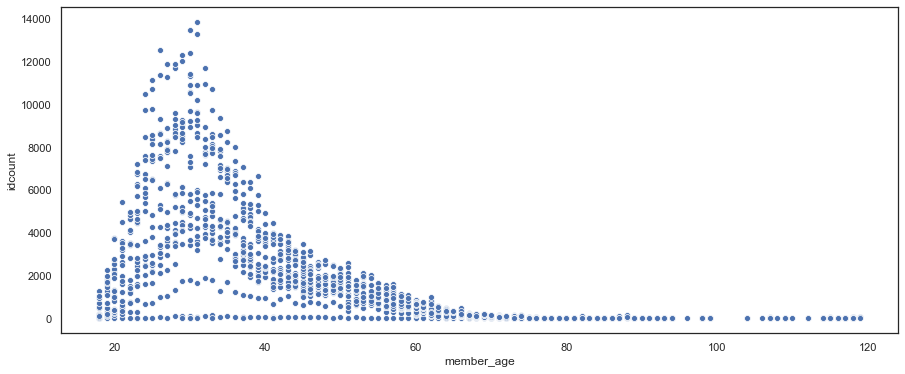

In [132]:
f = plt.figure(figsize=(15, 6))
ax = sns.scatterplot(x="member_age", y="idcount",
                  data=df_birth_years);

#### Assume keying entry for birth year between 1901 and 1930
- It would be easy to hit an 0 before a 1,2, or 3 - e.g. 1903 instead of 1930
- Or to hit a 1 before a 2, 3 - e.g. 1913 instead of 1931

In [133]:
df_birth_years.loc[df_birth_years.member_birth_year==1902].head()

,yearmonth,member_birth_year,idcount,member_age
0,201706,1902.000000000000,5,115.000000000000
58,201707,1902.000000000000,39,115.000000000000
124,201708,1902.000000000000,50,115.000000000000
192,201709,1902.000000000000,30,115.000000000000
259,201710,1902.000000000000,26,115.000000000000


### Test calculation of Age based on rectified year values

In [134]:
for yy in range(1901, 1930):
    nyy = 1900 + int(str(yy)[-1] + str(yy)[-2])
    if nyy > yy:
        print(yy, "-->", nyy)

1901 --> 1910
1902 --> 1920
1903 --> 1930
1904 --> 1940
1905 --> 1950
1906 --> 1960
1907 --> 1970
1908 --> 1980
1909 --> 1990
1912 --> 1921
1913 --> 1931
1914 --> 1941
1915 --> 1951
1916 --> 1961
1917 --> 1971
1918 --> 1981
1919 --> 1991
1923 --> 1932
1924 --> 1942
1925 --> 1952
1926 --> 1962
1927 --> 1972
1928 --> 1982
1929 --> 1992


It takes a very long time if .loc is used with `member_birth_year`, so instead the `fix_age` function sets the index to `member_birth_year` and uses .loc on the passed year value. Then, it assembles a bulk update of the age values corresponding to the current index, and updates to it using the index.

In [135]:
df_birth_years.set_index('member_birth_year', inplace=True)

In [136]:
def fix_age(df, yy, nyy):
    if nyy > yy and yy in df.index.values:
        print(yy, "-->", nyy)
        yy_idx = df.index == yy
        nyy_fix = df.loc[yy_idx, ["yearmonth"]].astype(int) // 100 - nyy
        nyy_fix = list(nyy_fix.yearmonth)
        df.loc[yy_idx, ["member_age"]] = nyy_fix

In [137]:
%%time
for yy in range(1901, 1930):
    nyy = 1900 + int(str(yy)[-1] + str(yy)[-2])
    fix_age(df_birth_years,yy,nyy)

1901 --> 1910
1902 --> 1920
1903 --> 1930
1904 --> 1940
1906 --> 1960
1907 --> 1970
1909 --> 1990
1914 --> 1941
1923 --> 1932
1924 --> 1942
1927 --> 1972
1928 --> 1982
Wall time: 46 ms


In [138]:
df_birth_years.reset_index(inplace=True)

In [139]:
df_birth_years.loc[df_birth_years.member_birth_year==1902].head()

,member_birth_year,yearmonth,idcount,member_age
0,1902.000000000000,201706,5,97.000000000000
58,1902.000000000000,201707,39,97.000000000000
124,1902.000000000000,201708,50,97.000000000000
192,1902.000000000000,201709,30,97.000000000000
259,1902.000000000000,201710,26,97.000000000000


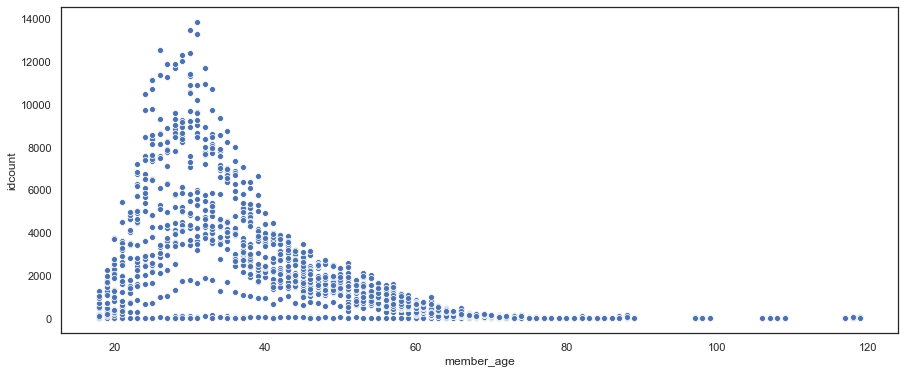

In [140]:
f = plt.figure(figsize=(15, 6))
ax = sns.scatterplot(x="member_age", y="idcount",
                  data=df_birth_years);

In [141]:
df_birth_years.member_age.value_counts().sort_index()

18.000000000000     23
19.000000000000     23
20.000000000000     23
21.000000000000     23
22.000000000000     23
23.000000000000     25
24.000000000000     23
25.000000000000     23
26.000000000000     23
27.000000000000     23
28.000000000000     25
29.000000000000     24
30.000000000000     27
31.000000000000     24
32.000000000000     23
33.000000000000     24
34.000000000000     23
35.000000000000     29
36.000000000000     27
37.000000000000     25
38.000000000000     23
39.000000000000     23
40.000000000000     23
41.000000000000     26
42.000000000000     23
43.000000000000     23
44.000000000000     23
45.000000000000     23
46.000000000000     25
47.000000000000     26
48.000000000000     23
49.000000000000     23
50.000000000000     23
51.000000000000     23
52.000000000000     23
53.000000000000     23
54.000000000000     23
55.000000000000     23
56.000000000000     23
57.000000000000     23
58.000000000000     25
59.000000000000     23
60.000000000000     23
61.00000000

In [142]:
df_birth_years.loc[df_birth_years.member_age >= 97].groupby("member_birth_year")["idcount"].count() 

member_birth_year
1900.000000000000    22
1901.000000000000    12
1902.000000000000    23
1910.000000000000    1 
1911.000000000000    11
1920.000000000000    13
Name: idcount, dtype: int64

#### Final manual adjustments
- The minimum age is 18, so don't adjust to anything below that
- 1900 --> 1990
- 1901 --> 1991
- 1902 --> 1992
- 1903 --> 1993
- 1910 --> 1991
- 1911 --> 1991
- 1912 --> 1992
- 1913 --> 1993
- 1920 --> 1992
- 1930 --> 1993
- 1931 --> 1991
- 1932 --> 1992
- 1933 --> 1993

In [143]:
df_birth_years.set_index('member_birth_year', inplace=True)

In [144]:
%%time
fix_age(df_birth_years,1900,1990)
fix_age(df_birth_years,1901,1991)
fix_age(df_birth_years,1902,1992)
fix_age(df_birth_years,1903,1993)
fix_age(df_birth_years,1910,1990)
fix_age(df_birth_years,1911,1991)
fix_age(df_birth_years,1912,1992)
fix_age(df_birth_years,1913,1993)
fix_age(df_birth_years,1920,1992)
fix_age(df_birth_years,1930,1993)
fix_age(df_birth_years,1931,1991)
fix_age(df_birth_years,1932,1992)
fix_age(df_birth_years,1933,1993)
# leaving this "oldie" but not so old!
fix_age(df_birth_years,1923,1932)

1900 --> 1990
1901 --> 1991
1902 --> 1992
1903 --> 1993
1910 --> 1990
1911 --> 1991
1920 --> 1992
1930 --> 1993
1931 --> 1991
1932 --> 1992
1933 --> 1993
1923 --> 1932
Wall time: 51 ms


In [145]:
df_birth_years.reset_index(inplace=True)

In [146]:
df_birth_years.loc[df_birth_years.member_birth_year == 1900].head()

,member_birth_year,yearmonth,idcount,member_age
57,1900.000000000000,201707,3,27.000000000000
123,1900.000000000000,201708,13,27.000000000000
190,1900.000000000000,201709,19,27.000000000000
258,1900.000000000000,201710,37,27.000000000000
326,1900.000000000000,201711,37,27.000000000000


In [147]:
df_birth_years.loc[df_birth_years.member_age > 85]

,member_birth_year,yearmonth,idcount,member_age
1571,1923.000000000000,201904,6,87.000000000000


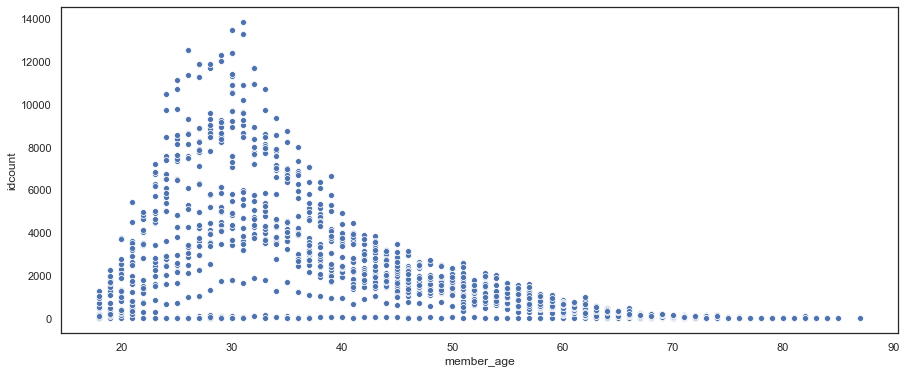

In [148]:
f = plt.figure(figsize=(15, 6))
ax = sns.scatterplot(x="member_age", y="idcount",
                  data=df_birth_years);

In [149]:
df_birth_years.member_age.mean()

47.89390243902439

In [150]:
df_birth_years.member_age.median()

47.0

### Create `member_age` column

In [151]:
df_fordgo["member_age"] = df_fordgo.yearmonth.astype(int) // 100 - df_fordgo.member_birth_year

In [152]:
df_fordgo.set_index('member_birth_year', inplace=True)

In [153]:
%%time
yy_idx = df_fordgo.index < 1900
nyy_fix = df_fordgo.loc[yy_idx, ["member_age"]] - 100
nyy_fix = list(nyy_fix.member_age)

df_fordgo.loc[yy_idx, ["member_age"]] = nyy_fix

Wall time: 457 ms


In [154]:
%%time
for yy in range(1901, 1930):
    nyy = 1900 + int(str(yy)[-1] + str(yy)[-2])
    fix_age(df_fordgo,yy,nyy)

1901 --> 1910
1902 --> 1920
1903 --> 1930
1904 --> 1940
1906 --> 1960
1907 --> 1970
1909 --> 1990
1914 --> 1941
1923 --> 1932
1924 --> 1942
1927 --> 1972
1928 --> 1982
Wall time: 1.74 s


In [155]:
%%time
fix_age(df_fordgo,1900,1990)
fix_age(df_fordgo,1901,1991)
fix_age(df_fordgo,1902,1992)
fix_age(df_fordgo,1903,1993)
fix_age(df_fordgo,1910,1990)
fix_age(df_fordgo,1911,1991)
fix_age(df_fordgo,1912,1992)
fix_age(df_fordgo,1913,1993)
fix_age(df_fordgo,1920,1992)
fix_age(df_fordgo,1930,1993)
fix_age(df_fordgo,1931,1991)
fix_age(df_fordgo,1932,1992)
fix_age(df_fordgo,1933,1993)
fix_age(df_fordgo,1923,1932)

1900 --> 1990
1901 --> 1991
1902 --> 1992
1903 --> 1993
1910 --> 1990
1911 --> 1991
1920 --> 1992
1930 --> 1993
1931 --> 1991
1932 --> 1992
1933 --> 1993
1923 --> 1932
Wall time: 1.47 s


In [156]:
df_fordgo.reset_index(inplace=True)

In [157]:
df_fordgo = df_fordgo[["recid","rowindex","duration_sec","start_time","end_time","start_station_id","start_station_name",
                       "start_station_latitude","start_station_longitude","end_station_id","end_station_name",
                       "end_station_latitude","end_station_longitude","bike_id","user_type","member_birth_year",
                       "member_gender","bike_share_for_all_trip","rental_access_method","datasource","has_start_id",
                       "has_end_id","has_start_name","has_end_name","yearmonth","member_age"]].copy()

In [158]:
df_fordgo.head(2)

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
0,1,0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776434819200,-122.426244020500,43,San Francisco Public Library (Grove St at Hyde St),37.778767700000,-122.415929200000,96,Customer,1987.000000000000,Male,None,None,2017,True,True,True,True,201712,30.000000000000
1,2,1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at 3rd St),37.784872084400,-122.400875687600,96,Dolores St at 15th St,37.766210200000,-122.426613600000,88,Customer,1965.000000000000,Female,None,None,2017,True,True,True,True,201712,52.000000000000


In [159]:
df_fordgo.loc[df_fordgo.member_birth_year==1888].head(2)

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
1604852,1604853,66766,766,2018-08-21 12:32:52.208,2018-08-21 12:45:38.971,50,2nd St at Townsend St,37.780526000000,-122.390288000000,44,Civic Center/UN Plaza BART Station (Market St at McAllister St),37.781073700000,-122.411738200000,4319,Subscriber,1888.000000000000,Other,No,None,201808,True,True,True,True,201808,30.000000000000
1604901,1604902,66815,2034,2018-08-21 11:55:20.227,2018-08-21 12:29:14.760,44,Civic Center/UN Plaza BART Station (Market St at McAllister St),37.781073700000,-122.411738200000,50,2nd St at Townsend St,37.780526000000,-122.390288000000,4319,Subscriber,1888.000000000000,Other,No,None,201808,True,True,True,True,201808,30.000000000000


In [160]:
df_fordgo.loc[df_fordgo.member_birth_year==1920].head(2)

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
846508,846509,13906,565,2018-04-27 18:49:22.618,2018-04-27 18:58:48.383,66,3rd St at Townsend St,37.778741611500,-122.392740827100,16,Steuart St at Market St,37.794130000000,-122.394430000000,3303,Subscriber,1920.000000000000,Male,No,None,201804,True,True,True,True,201804,26.000000000000
852901,852902,20299,710,2018-04-26 18:19:49.399,2018-04-26 18:31:39.779,81,Berry St at 4th St,37.775880000000,-122.393170000000,15,San Francisco Ferry Building (Harry Bridges Plaza),37.795392000000,-122.394203000000,2410,Subscriber,1920.000000000000,Male,No,None,201804,True,True,True,True,201804,26.000000000000


In [161]:
df_fordgo.loc[df_fordgo.member_birth_year==1900].head(2)

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
287,288,287,581,2017-12-31 18:10:46.556,2017-12-31 18:20:28.352,274,Oregon St at Adeline St,37.857567200000,-122.267558300000,173,Shattuck Ave at 55th Ave,37.840364300000,-122.264488100000,3050,Subscriber,1900.000000000000,Male,None,None,2017,True,True,True,True,201712,27.000000000000
1751,1752,1751,370,2017-12-30 17:17:54.969,2017-12-30 17:24:05.481,207,Broadway at Coronado Ave,37.835788300000,-122.251620700000,173,Shattuck Ave at 55th Ave,37.840364300000,-122.264488100000,456,Subscriber,1900.000000000000,Male,None,None,2017,True,True,True,True,201712,27.000000000000


In [162]:
df_fordgo.tail(2)

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
5795409,5795410,176797,340,2020-04-01 13:07:34,2020-04-01 13:13:14,,None,37.848530166700,-122.266013000000,,None,37.848497000000,-122.266029166700,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202003,nan
5795410,5795411,176798,333,2020-03-23 16:39:57,2020-03-23 16:45:30,,None,37.848625000000,-122.266659833300,,None,37.848445833300,-122.266021500000,633095,Subscriber,nan,None,None,app,202003,False,False,False,False,202003,nan


### Check `member_age` values

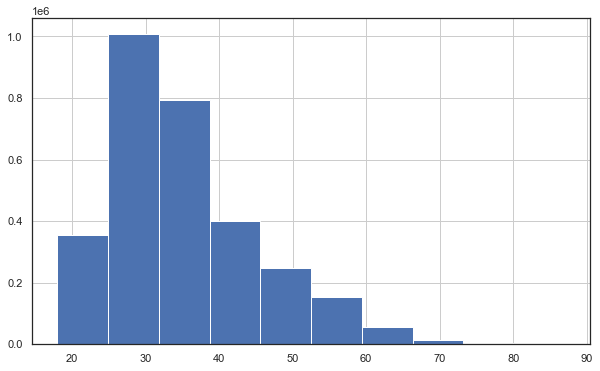

In [163]:
df_fordgo.member_age.hist(bins=10);

In [164]:
df_fordgo.member_age.describe(percentiles = [.25, .5, .75, .95, .99]).round(2)

count   3036159.000000000000
mean    34.910000000000     
std     10.120000000000     
min     18.000000000000     
25%     28.000000000000     
50%     33.000000000000     
75%     40.000000000000     
95%     55.000000000000     
99%     64.000000000000     
max     87.000000000000     
Name: member_age, dtype: float64

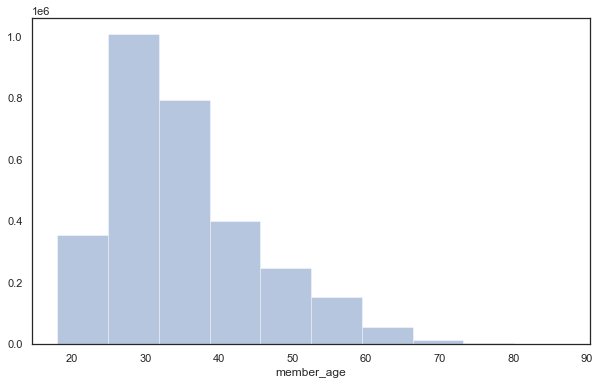

In [165]:
sns.distplot(df_fordgo.member_age, kde=False, bins=10);

#### There are some spikes in the age ditributions
- Depending on the number of bins
- Possibly due to the manual fixing of ages

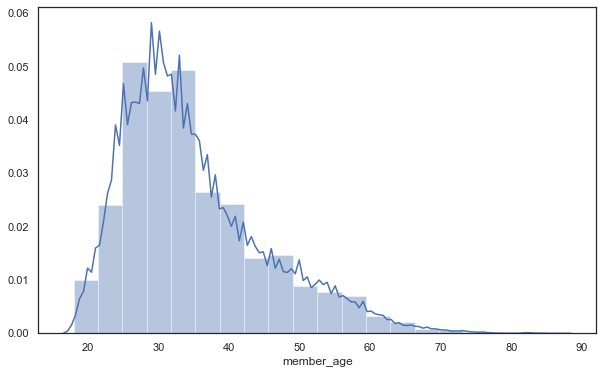

In [166]:
sns.distplot(df_age_gender.member_age, bins=20);

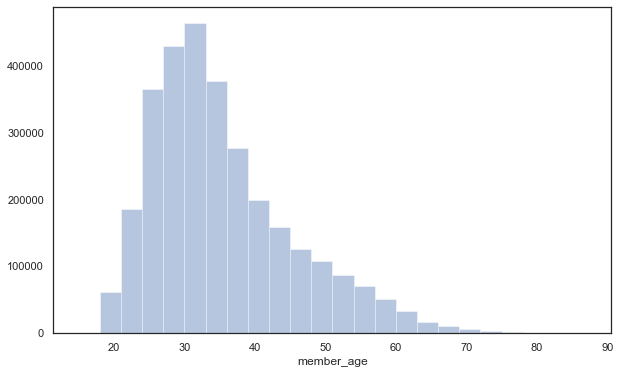

In [167]:
bin_edges = np.arange(15, df_age_gender.member_age.max()+1, 3)
sns.distplot(df_age_gender.member_age, bins=bin_edges, kde=False);

### Year of Birth conclusions
- Year of birth has a considerable number of errors
- Making assumptions about data entry key transposition errors allows these to be worked around
- I have left the original year value alone, but have added an Age calculation that accounts for keying errors
- The biggest group are aged 25 to 35

----

## 6. Age vs. gender trips distributions
- Age and gender exist in the data together, after April 2019 these are no longer available

In [168]:
df_age_gender = df_fordgo.loc[df_fordgo.member_gender.notna() & df_fordgo.member_age.notna(), ["member_gender","member_age"]]

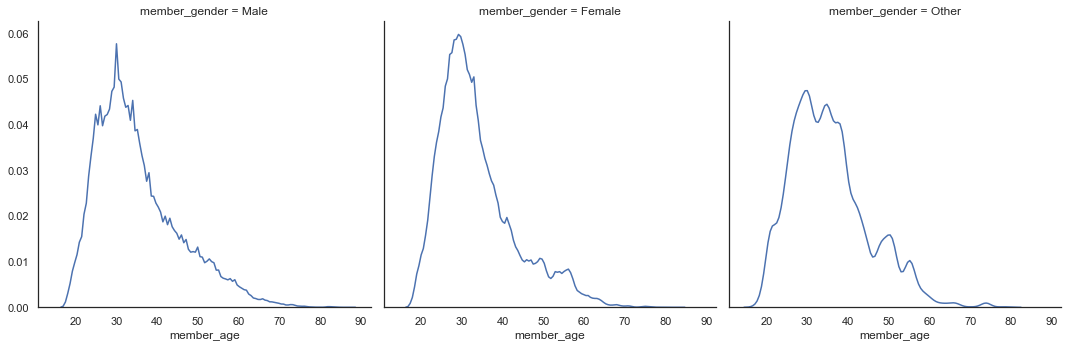

In [169]:
g = sns.FacetGrid(df_age_gender, col="member_gender", height=5)
g.map(sns.kdeplot, "member_age");

In [170]:
bin_edges = np.arange(15, df_age_gender.member_age.max()+1, 3)
bin_edges

array([15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 45., 48., 51.,
       54., 57., 60., 63., 66., 69., 72., 75., 78., 81., 84., 87.])

In [171]:
bin_edges = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
bin_names = ["18-20","20-25","25-30","30-35","35-40","40-45","45-50","50-55",
             "55-60","60-65","65-70","70-75","75-80","80-85","85-90"]

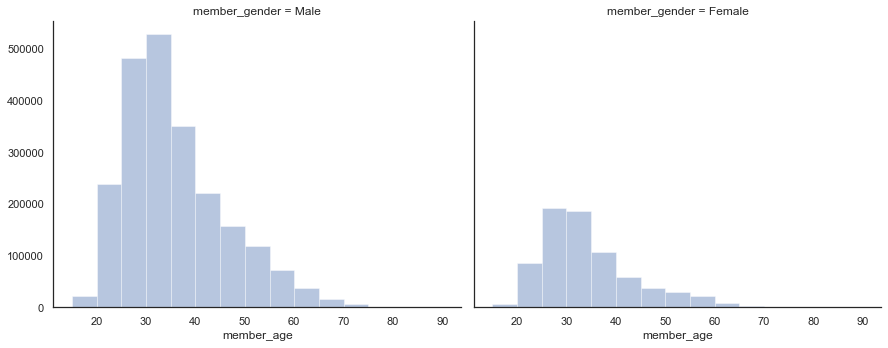

In [172]:
g = sns.FacetGrid(df_age_gender.loc[df_age_gender.member_gender != "Other"], col="member_gender", height=5, aspect=1.25)
g.map(sns.distplot, "member_age", kde=False, bins=bin_edges);

In [173]:
df_age_gender['age_group'] = pd.cut(df_age_gender.member_age, bin_edges, labels=bin_names)

In [174]:
bin_edges = [10,20,30,40,50,60,70,80,90]
bin_names = ["18-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90"]

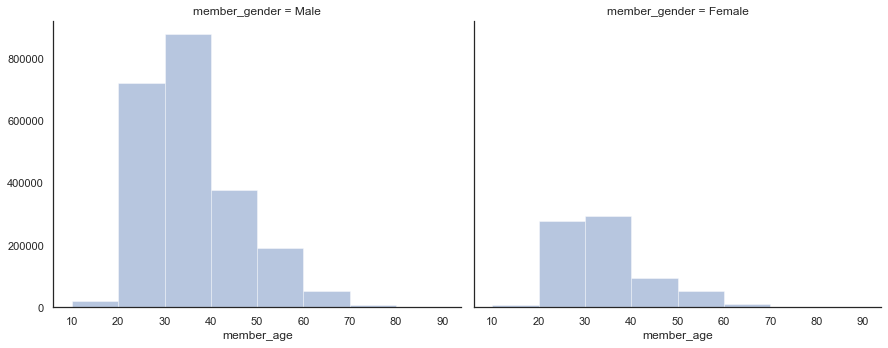

In [175]:
g = sns.FacetGrid(df_age_gender.loc[df_age_gender.member_gender != "Other"], col="member_gender", height=5, aspect=1.25)
g.map(sns.distplot, "member_age", kde=False, bins=bin_edges);

In [176]:
df_age_gender['age_group_2'] = pd.cut(df_age_gender.member_age, bin_edges, labels=bin_names)

In [177]:
df_age_gender.head()

,member_gender,member_age,age_group,age_group_2
0,Male,30.000000000000,25-30,20-30
1,Female,52.000000000000,50-55,50-60
4,Female,20.000000000000,18-20,18-20
6,Female,26.000000000000,25-30,20-30
12,Male,27.000000000000,25-30,20-30


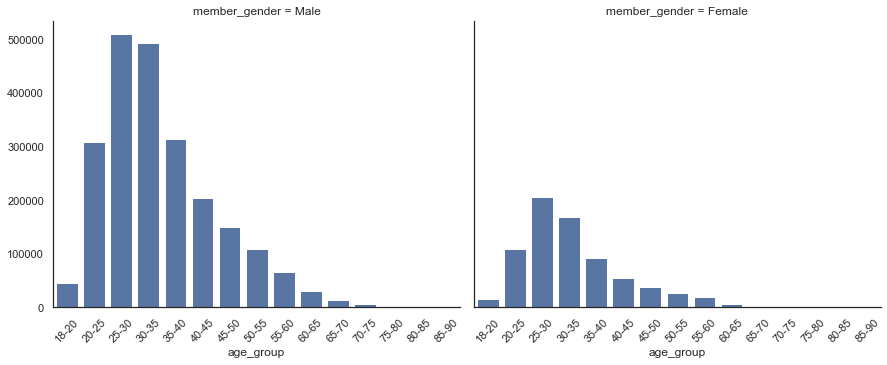

In [178]:
g = sns.FacetGrid(df_age_gender.loc[df_age_gender.member_gender != "Other"], col="member_gender", height=5, aspect=1.25)
cht = g.map(sns.countplot, "age_group");
cht.set_xticklabels(rotation=45);

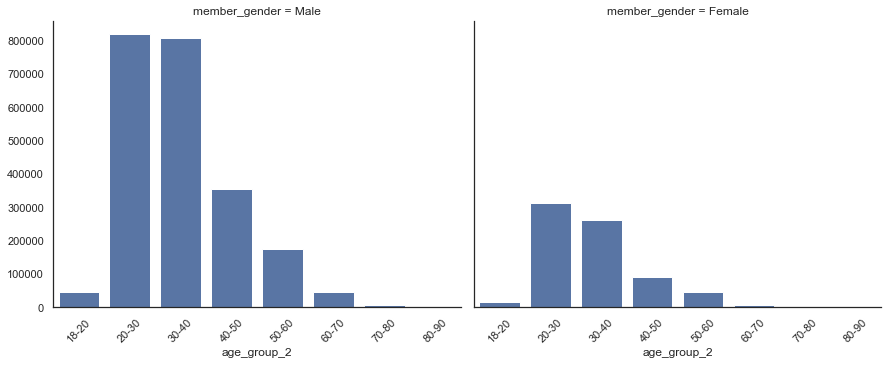

In [179]:
g = sns.FacetGrid(df_age_gender.loc[df_age_gender.member_gender != "Other"], col="member_gender", height=5, aspect=1.25)
cht = g.map(sns.countplot, "age_group_2");
cht.set_xticklabels(rotation=45);

In [180]:
bin_edges = [15,25,30,35,40,45,50,55,60,70,80]
bin_order = [1,2,3,4,5,6,7,8,9,10]
bin_names = ["18-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-70","70+"]

In [181]:
df_age_gender['age_group_3'] = pd.cut(df_age_gender.member_age, bin_edges, labels=bin_names)
df_age_gender['age_grp3_order'] = pd.cut(df_age_gender.member_age, bin_edges, labels=bin_order)

In [182]:
df_age_gender.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3036159 entries, 0 to 3254324
Data columns (total 6 columns):
 #   Column          Dtype   
---  ------          -----   
 0   member_gender   object  
 1   member_age      float64 
 2   age_group       category
 3   age_group_2     category
 4   age_group_3     category
 5   age_grp3_order  category
dtypes: category(4), float64(1), object(1)
memory usage: 81.1+ MB


In [183]:
df_age_gender.head()

,member_gender,member_age,age_group,age_group_2,age_group_3,age_grp3_order
0,Male,30.000000000000,25-30,20-30,25-30,2
1,Female,52.000000000000,50-55,50-60,50-55,7
4,Female,20.000000000000,18-20,18-20,18-25,1
6,Female,26.000000000000,25-30,20-30,25-30,2
12,Male,27.000000000000,25-30,20-30,25-30,2


G:\Anaconda3\envs\pytorch_1_4\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


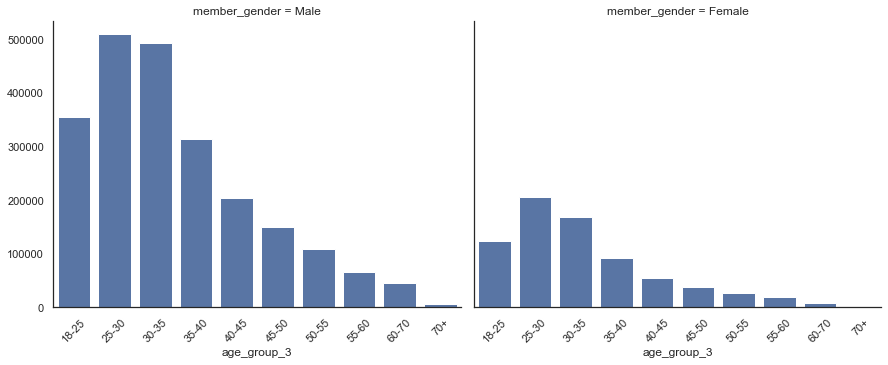

In [184]:
g = sns.FacetGrid(df_age_gender.loc[df_age_gender.member_gender != "Other"], col="member_gender", height=5, aspect=1.25)
cht = g.map(sns.countplot, "age_group_3");
cht.set_xticklabels(rotation=45);

### Add an `age_group` categorical column

In [185]:
bin_edges = [15,25,30,35,40,45,50,55,60,70,80]
bin_order = [1,2,3,4,5,6,7,8,9,10]
bin_names = ["18-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-70","70+"]

In [186]:
df_fordgo['age_group'] = pd.cut(df_fordgo.member_age, bin_edges, labels=bin_names)
df_fordgo['age_grp_order'] = pd.cut(df_fordgo.member_age, bin_edges, labels=bin_order)

### Age vs Gender conclusion
- The range of and distributions of ages between men and women is roughly similar
- However, older women are unlikely customers compared to men
- The data fix for key errors is likely to have introduced some incorrect values but these are not significant
- Adding age categories makes it easier to visualize the data

----

## 7. Duration

In [187]:
df_fordgo.duration_sec.min(), df_fordgo.duration_sec.max()

(60, 912110)

#### The maximum duration is excessive - 253 hours!

In [188]:
df_fordgo.duration_sec.max() / (60*60)

253.36388888888888

#### 5,390 trips lasted for longer than 10 hours

In [189]:
len(df_fordgo.loc[df_fordgo.duration_sec > (10*60*60)])

5390

#### 2 trips lasted for longer than 24 hours

In [190]:
len(df_fordgo.loc[df_fordgo.duration_sec > (24*60*60)])

2

#### These 2 trips were for 10 days each
- both were for dockless bikes...

In [191]:
df_fordgo.loc[df_fordgo.duration_sec > (24*60*60)]

,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,datasource,has_start_id,has_end_id,has_start_name,has_end_name,yearmonth,member_age
4864697,4864698,124395,912110,2019-12-19 23:15:36,2019-12-30 12:37:26,,None,37.323757000000,-121.878614000000,,None,37.327655833300,-121.868597666700,614329,Customer,nan,None,None,app,201912,False,False,False,False,201912,nan
5011572,5011573,121168,811077,2020-01-09 16:23:21,2020-01-19 01:41:19,,None,37.336035166700,-121.899836000000,,None,37.336549500000,-121.900960666700,231296,Subscriber,nan,None,None,clipper,202001,False,False,False,False,202001,nan


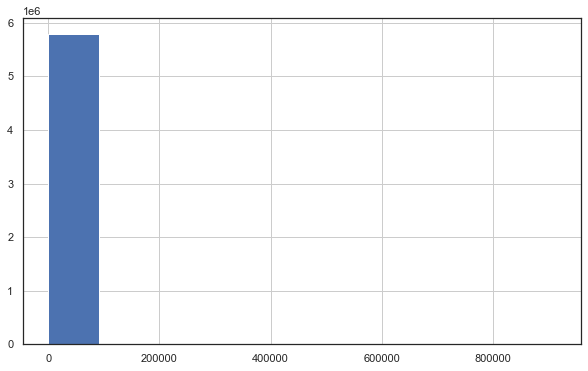

In [192]:
df_fordgo.duration_sec.hist();

In [193]:
df_fordgo.duration_sec.describe(percentiles = [.25, .5, .75, .95, .99]).round(2)

count   5795411.000000000000
mean    849.610000000000    
std     2233.870000000000   
min     60.000000000000     
25%     360.000000000000    
50%     572.000000000000    
75%     893.000000000000    
95%     1824.000000000000   
99%     4989.000000000000   
max     912110.000000000000 
Name: duration_sec, dtype: float64

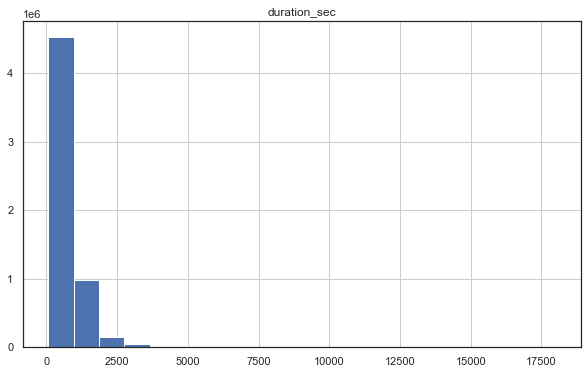

In [194]:
df_fordgo.loc[df_fordgo.duration_sec <= (5*60*60),["duration_sec"]].hist(bins=20);

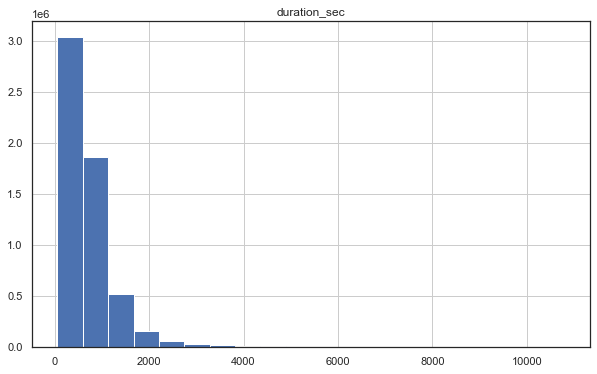

In [195]:
df_fordgo.loc[df_fordgo.duration_sec <= (3*60*60),["duration_sec"]].hist(bins=20);

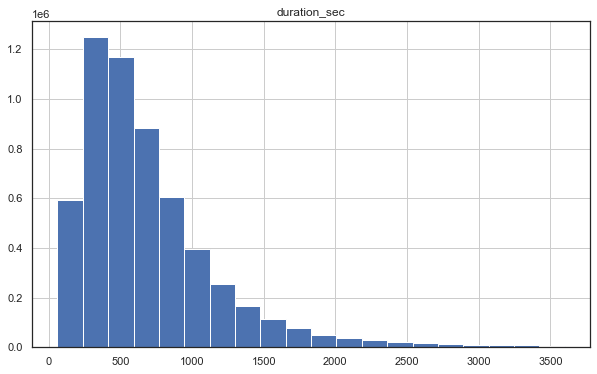

In [196]:
df_fordgo.loc[df_fordgo.duration_sec <= (1*60*60),["duration_sec"]].hist(bins=20);

### Add minute and hours duration columns

In [197]:
df_fordgo["duration_hrs"] = df_fordgo.duration_sec / (60*60)
df_fordgo["duration_min"] = df_fordgo.duration_sec / 60

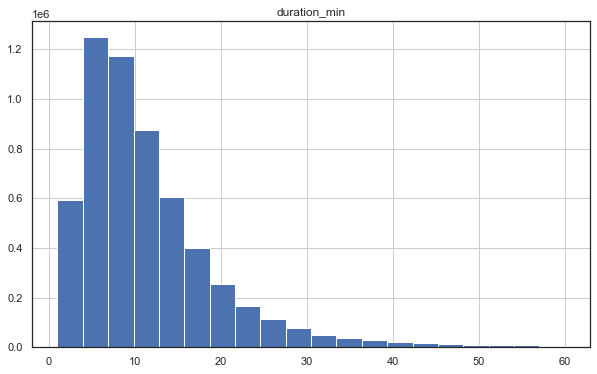

In [198]:
df_fordgo.loc[df_fordgo.duration_min <= 60,["duration_min"]].hist(bins=20);

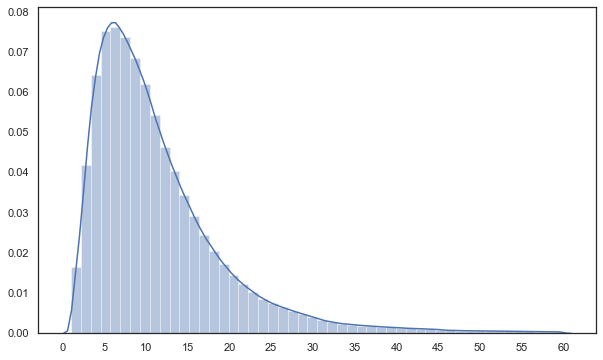

In [199]:
ax = sns.distplot(df_fordgo.loc[df_fordgo.duration_min <= 60,["duration_min"]]);
stepsize = 5
start, end = (0, 65) # ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize));

### Duration conclusion
- There are a couple of hires that last days, the rest mostly last less than 20 minutes
- Adding duration in minutes and hours makes for easier visualization

----

## 8. Remaining Categorical fields
- bike_share_for_all_trip 
- rental_access_method
- user_type

In [200]:
df_fordgo.bike_share_for_all_trip.value_counts()

No     3787538
Yes    339907 
Name: bike_share_for_all_trip, dtype: int64

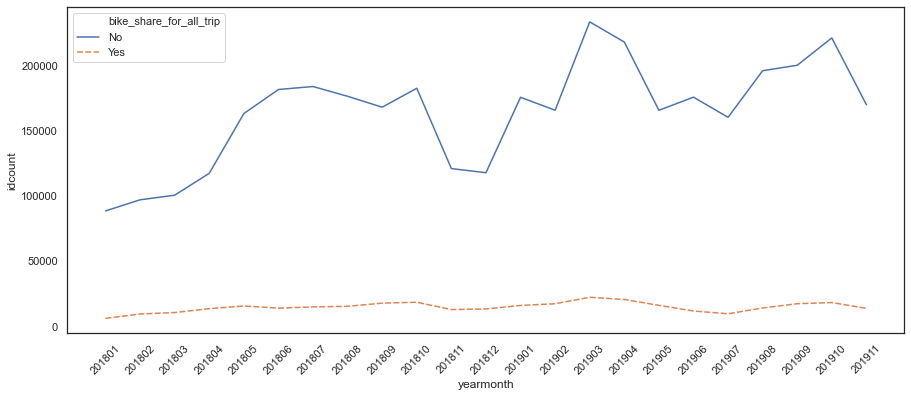

In [201]:
df_bike_share = df_fordgo[["yearmonth", "bike_share_for_all_trip"]].groupby(
              ["yearmonth", "bike_share_for_all_trip"]).size().reset_index()
df_bike_share.columns=["yearmonth", "bike_share_for_all_trip","idcount"]

f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="yearmonth", y="idcount",
                  hue="bike_share_for_all_trip", 
                  style="bike_share_for_all_trip", 
                  data=df_bike_share)
plt.xticks(rotation=45);

In [202]:
df_fordgo.rental_access_method.value_counts()

app        678481
clipper    60215 
Name: rental_access_method, dtype: int64

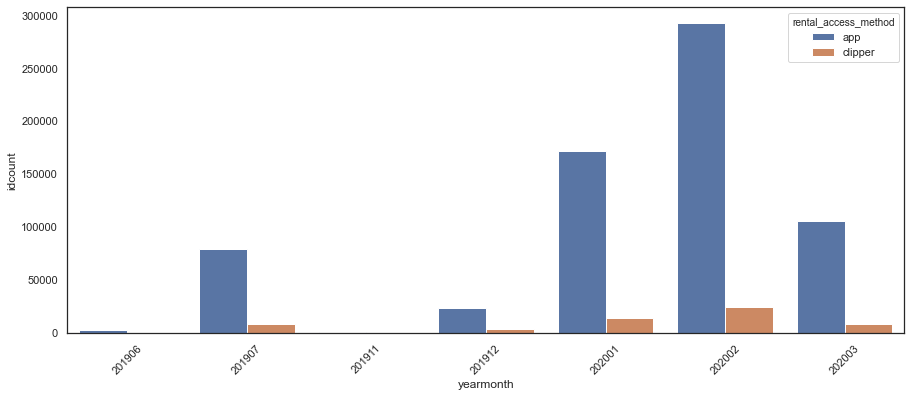

In [203]:
df_rental_access = df_fordgo[["yearmonth", "rental_access_method"]].groupby(
              ["yearmonth", "rental_access_method"]).size().reset_index()
df_rental_access.columns=["yearmonth", "rental_access_method","idcount"]

f = plt.figure(figsize=(15, 6))
ax = sns.barplot(x="yearmonth", y="idcount",
                  hue="rental_access_method", 
                  data=df_rental_access)
plt.xticks(rotation=45);

In [204]:
df_fordgo.user_type.value_counts()

Subscriber    4558646
Customer      1236765
Name: user_type, dtype: int64

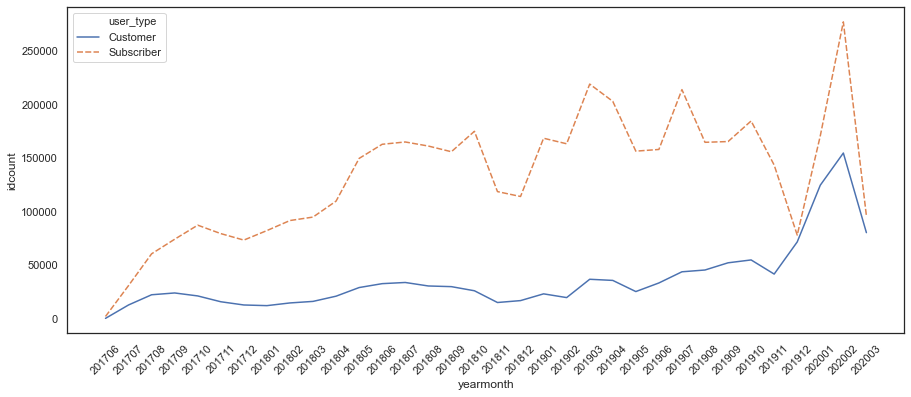

In [205]:
df_user_type = df_fordgo[["yearmonth", "user_type"]].groupby(
              ["yearmonth", "user_type"]).size().reset_index()
df_user_type.columns=["yearmonth", "user_type","idcount"]

f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="yearmonth", y="idcount",
                  hue="user_type", 
                  style="user_type", 
                  data=df_user_type)
plt.xticks(rotation=45);

### Conclusion re remaining categorical fields
- `user_type` of "Customer" and "Subscriber" look like useful fields for multivariate data investigation
- `bike_share_for_all_trip` is mostly "No" - I need to find out what this refers to before deciding on its usefulness
- `rental_access_method` is mostly "app" so is unlikely to provide much insight

----

## 9. Add date-only, hour-only, day categorical and counter fields
- To assist with a aggregation add start and end date fields without seconds and time components
- Also add days information as categorical fields
- And add a counter field

In [206]:
%%time
df_fordgo["start_date"] = df_fordgo.start_time.dt.floor('d')
df_fordgo["end_date"] = df_fordgo.end_time.dt.floor('d')

Wall time: 386 ms


In [207]:
%%time
df_fordgo["start_year"] = df_fordgo.start_time.dt.year.astype(int)
df_fordgo["end_year"] = df_fordgo.end_time.dt.year.astype(int)

Wall time: 745 ms


In [208]:
%%time
df_fordgo["start_month"] = df_fordgo.start_time.dt.month.astype(int)
df_fordgo["end_month"] = df_fordgo.end_time.dt.month.astype(int)

Wall time: 728 ms


#### We already have `yearmonth` as a categorical, but that has been harmonized with the dataset boundaries
- These align with the start and end time values

In [209]:
%%time
df_fordgo["start_yearmonth"] = (pd.DatetimeIndex(df_fordgo.start_time).year * 100) +\
                                pd.DatetimeIndex(df_fordgo.start_time).month
df_fordgo["start_yearmonth"] = df_fordgo.start_yearmonth.astype(str)

Wall time: 4.13 s


In [210]:
%%time
df_fordgo["end_yearmonth"] = (pd.DatetimeIndex(df_fordgo.end_time).year * 100) +\
                                pd.DatetimeIndex(df_fordgo.end_time).month
df_fordgo["end_yearmonth"] = df_fordgo.end_yearmonth.astype(str)

Wall time: 4.11 s


In [211]:
%%time
df_fordgo["start_month_name"] = df_fordgo.start_time.dt.month_name()
df_fordgo["end_month_name"] = df_fordgo.end_time.dt.month_name()

Wall time: 2.87 s


In [212]:
%%time
df_fordgo["start_day"] = df_fordgo.start_time.dt.day.astype(int)
df_fordgo["end_day"] = df_fordgo.end_time.dt.day.astype(int)

Wall time: 730 ms


In [213]:
%%time
df_fordgo["start_day_name"] = df_fordgo.start_time.dt.day_name()
df_fordgo["end_day_name"] = df_fordgo.end_time.dt.day_name()

Wall time: 9.13 s


In [214]:
%%time
df_fordgo["start_hour"] = df_fordgo.start_time.dt.hour
df_fordgo["end_hour"] = df_fordgo.end_time.dt.hour

Wall time: 752 ms


In [215]:
df_fordgo["reccount"] = 1

In [216]:
df_fordgo.head()

,member_birth_year,recid,rowindex,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_gender,bike_share_for_all_trip,rental_access_method,datasource,yearmonth,has_start_id,has_end_id,has_start_name,has_end_name,member_age,age_group,age_grp_order,duration_hrs,duration_min,start_date,end_date,start_year,end_year,start_month,end_month,start_yearmonth,end_yearmonth,start_month_name,end_month_name,start_day,end_day,start_day_name,end_day_name,start_hour,end_hour,reccount
0,1987.000000000000,1,0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776434819200,-122.426244020500,43,San Francisco Public Library (Grove St at Hyde St),37.778767700000,-122.415929200000,96,Customer,Male,None,None,2017,201712,True,True,True,True,30.000000000000,25-30,2,22.252777777778,1335.166666666667,2017-12-31,2018-01-01,2017,2018,12,1,201712,201801,December,January,31,1,Sunday,Monday,16,15,1
1,1965.000000000000,2,1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at 3rd St),37.784872084400,-122.400875687600,96,Dolores St at 15th St,37.766210200000,-122.426613600000,88,Customer,Female,None,None,2017,201712,True,True,True,True,52.000000000000,50-55,7,21.888888888889,1313.333333333333,2017-12-31,2018-01-01,2017,2018,12,1,201712,201801,December,January,31,1,Sunday,Monday,15,13,1
2,nan,3,2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870347700000,-122.267763700000,245,Downtown Berkeley BART,37.870347700000,-122.267763700000,1094,Customer,None,None,None,2017,201712,True,True,True,True,nan,NaN,NaN,12.713333333333,762.800000000000,2017-12-31,2018-01-01,2017,2018,12,1,201712,201801,December,January,31,1,Sunday,Monday,22,11,1
3,nan,4,3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520401100,-122.409449368700,5,Powell St BART Station (Market St at 5th St),37.783899357100,-122.408444881400,2831,Customer,None,None,None,2017,201712,True,True,True,True,nan,NaN,NaN,17.270000000000,1036.200000000000,2017-12-31,2018-01-01,2017,2018,12,1,201712,201801,December,January,31,1,Sunday,Monday,17,10,1
4,1997.000000000000,5,4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868812600000,-122.258764000000,247,Fulton St at Bancroft Way,37.867789200000,-122.265896400000,3167,Subscriber,Female,None,None,2017,201712,True,True,True,True,20.000000000000,18-25,1,12.111944444444,726.716666666667,2017-12-31,2018-01-01,2017,2018,12,1,201712,201801,December,January,31,1,Sunday,Monday,14,2,1


### Cleanup dataframes no longer being used
- Activate as code and run as required....

# Process all changes
- The code below assembles all of the changes assessed throughout the notebook into one block
- The original `tripdata` table is loaded (or re-loaded if this notebook has been followed) into df_fordgo
- Then all changes are applied
- And the data saved back as table `tripdata_fixed`
- Then verified

In [ ]:
df_fordgo = load_df_from_sql(table_name="tripdata")

### Convert start and end time to datetime

In [218]:
%%time
df_fordgo["start_time"] = pd.to_datetime(df_fordgo.start_time)
df_fordgo["end_time"] = pd.to_datetime(df_fordgo.end_time)

### Add `yearmonth` column 
- Expands 2017 data to include month, otherwise aligns with the original data sources

In [219]:
%%time
df_fordgo["yearmonth"] = (pd.DatetimeIndex(df_fordgo.start_time).year * 100) + pd.DatetimeIndex(df_fordgo.start_time).month
df_fordgo.loc[(df_fordgo.datasource != "2017") & 
              (df_fordgo.yearmonth != df_fordgo.datasource), ["yearmonth"]] = df_fordgo.datasource
df_fordgo["yearmonth"] = df_fordgo.yearmonth.astype(str)

### Round latitude and longitude to 10 decimals

In [220]:
%%time
df_fordgo["start_station_latitude"] = round(df_fordgo["start_station_latitude"], 10)
df_fordgo["start_station_longitude"] = round(df_fordgo["start_station_longitude"], 10)
df_fordgo["end_station_latitude"] = round(df_fordgo["end_station_latitude"], 10)
df_fordgo["end_station_longitude"] = round(df_fordgo["end_station_longitude"], 10)

### Convert start and end station to strings, add flags
- Add flags to say whether or not station values exist
- Blank out `nan` values

In [221]:
%%time
df_fordgo["start_station_id"] = df_fordgo.start_station_id.astype(str).replace('\.0', '', regex=True)
df_fordgo["end_station_id"] = df_fordgo.end_station_id.astype(str).replace('\.0', '', regex=True)
df_fordgo["has_start_id"] = True
df_fordgo["has_end_id"] = True
df_fordgo.loc[df_fordgo.start_station_id=="nan", ["has_start_id"]] = False
df_fordgo.loc[df_fordgo.end_station_id=="nan", ["has_end_id"]] = False
df_fordgo.loc[df_fordgo.has_start_id == False, ["start_station_id"]] = ""
df_fordgo.loc[df_fordgo.has_end_id == False, ["end_station_id"]] = ""

### Add flags for station names
- Flag to say whether station names exist

In [222]:
df_fordgo["has_start_name"] = True
df_fordgo["has_end_name"] = True
df_fordgo.loc[df_fordgo.start_station_name.isna(), ["has_start_name"]] = False
df_fordgo.loc[df_fordgo.end_station_name.isna(), ["has_end_name"]] = False

### Add member age column
- As part of this, fix values that are too large, using approach that assumes transposition of keys during data entry of birth year

In [223]:
def fix_age(df, yy, nyy):
    if nyy > yy and yy in df.index.values:
        print(yy, "-->", nyy)
        yy_idx = df.index == yy
        nyy_fix = df.loc[yy_idx, ["yearmonth"]].astype(int) // 100 - nyy
        nyy_fix = list(nyy_fix.yearmonth)
        df.loc[yy_idx, ["member_age"]] = nyy_fix

In [224]:
%%time
df_fordgo["member_age"] = df_fordgo.yearmonth.astype(int) // 100 - df_fordgo.member_birth_year

df_fordgo.set_index('member_birth_year', inplace=True)

yy_idx = df_fordgo.index < 1900
nyy_fix = df_fordgo.loc[yy_idx, ["member_age"]] - 100
nyy_fix = list(nyy_fix.member_age)
df_fordgo.loc[yy_idx, ["member_age"]] = nyy_fix

for yy in range(1901, 1930):
    nyy = 1900 + int(str(yy)[-1] + str(yy)[-2])
    fix_age(df_fordgo,yy,nyy)

fix_age(df_fordgo,1900,1990)
fix_age(df_fordgo,1901,1991)
fix_age(df_fordgo,1902,1992)
fix_age(df_fordgo,1903,1993)
fix_age(df_fordgo,1910,1990)
fix_age(df_fordgo,1911,1991)
fix_age(df_fordgo,1912,1992)
fix_age(df_fordgo,1913,1993)
fix_age(df_fordgo,1920,1992)
fix_age(df_fordgo,1930,1993)
fix_age(df_fordgo,1931,1991)
fix_age(df_fordgo,1932,1992)
fix_age(df_fordgo,1933,1993)
fix_age(df_fordgo,1923,1932)    

df_fordgo.reset_index(inplace=True)

### Add age groups column

In [225]:
%%time
bin_edges = [15,25,30,35,40,45,50,55,60,70,80]
bin_order = [1,2,3,4,5,6,7,8,9,10]
bin_names = ["18-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-70","70+"]
df_fordgo['age_group'] = pd.cut(df_fordgo.member_age, bin_edges, labels=bin_names)
df_fordgo['age_grp_order'] = pd.cut(df_fordgo.member_age, bin_edges, labels=bin_order)

### Add extra columns for describing date and time
- Year and Month of the datetime start and end values
- Date, and hour versions of the datetime start and end values
- Month and day of month numbers 
- Name of day and month

In [226]:
%%time
df_fordgo["duration_hrs"] = df_fordgo.duration_sec / (60*60)
df_fordgo["duration_min"] = df_fordgo.duration_sec / 60

df_fordgo["start_date"] = df_fordgo.start_time.dt.floor('d')
df_fordgo["end_date"] = df_fordgo.end_time.dt.floor('d')
df_fordgo["start_year"] = df_fordgo.start_time.dt.year.astype(int)
df_fordgo["end_year"] = df_fordgo.end_time.dt.year.astype(int)
df_fordgo["start_month"] = df_fordgo.start_time.dt.month.astype(int)
df_fordgo["end_month"] = df_fordgo.end_time.dt.month.astype(int)
df_fordgo["start_yearmonth"] = (pd.DatetimeIndex(df_fordgo.start_time).year * 100) +\
                                pd.DatetimeIndex(df_fordgo.start_time).month
df_fordgo["start_yearmonth"] = df_fordgo.start_yearmonth.astype(str)
df_fordgo["end_yearmonth"] = (pd.DatetimeIndex(df_fordgo.end_time).year * 100) +\
                                pd.DatetimeIndex(df_fordgo.end_time).month
df_fordgo["end_yearmonth"] = df_fordgo.end_yearmonth.astype(str)
df_fordgo["start_month_name"] = df_fordgo.start_time.dt.month_name()
df_fordgo["end_month_name"] = df_fordgo.end_time.dt.month_name()
df_fordgo["start_day"] = df_fordgo.start_time.dt.day.astype(int)
df_fordgo["end_day"] = df_fordgo.end_time.dt.day.astype(int)
df_fordgo["start_day_name"] = df_fordgo.start_time.dt.day_name()
df_fordgo["end_day_name"] = df_fordgo.end_time.dt.day_name()
df_fordgo["start_hour"] = df_fordgo.start_time.dt.hour
df_fordgo["end_hour"] = df_fordgo.end_time.dt.hour

### Add a count column
- Allows easy counting of data via a `SUM()`

In [227]:
df_fordgo["reccount"] = 1

## Store cleaned data in a new SQL Lite table

In [228]:
df_fordgo = df_fordgo[["recid","rowindex","duration_hrs","duration_min","duration_sec","start_time","end_time",
                       "start_date","start_yearmonth","start_year","start_month","start_month_name","start_day",
                       "start_day_name","start_hour",
                       "end_date","end_yearmonth","end_year","end_month","end_month_name","end_day",
                       "end_day_name","end_hour",
                       "start_station_id","has_start_id","start_station_name","has_start_name",
                       "start_station_latitude","start_station_longitude",
                       "end_station_id","has_end_id","end_station_name","has_end_name",
                       "end_station_latitude","end_station_longitude",
                       "bike_id","bike_share_for_all_trip","rental_access_method",
                       "user_type","member_birth_year","member_age","age_group","age_grp_order","member_gender",
                       "datasource","yearmonth","reccount"]].copy()

In [229]:
df_fordgo.columns

Index(['recid',
       'rowindex',
       'duration_hrs',
       'duration_min',
       'duration_sec',
       'start_time',
       'end_time',
       'start_date',
       'start_yearmonth',
       'start_year',
       'start_month',
       'start_month_name',
       'start_day',
       'start_day_name',
       'start_hour',
       'end_date',
       'end_yearmonth',
       'end_year',
       'end_month',
       'end_month_name',
       'end_day',
       'end_day_name',
       'end_hour',
       'start_station_id',
       'has_start_id',
       'start_station_name',
       'has_start_name',
       'start_station_latitude',
       'start_station_longitude',
       'end_station_id',
       'has_end_id',
       'end_station_name',
       'has_end_name',
       'end_station_latitude',
       'end_station_longitude',
       'bike_id',
       'bike_share_for_all_trip',
       'rental_access_method',
       'user_type',
       'member_birth_year',
       'member_age',
       'age_group',
    

In [230]:
%%time
save_df_to_sql(df_fordgo)

Wrote dataframe to tripdata_fixed in fordgobike.db
Wall time: 9min 5s


In [231]:
%%time
df_fordgo_test = load_df_from_sql(test=True)

Wall time: 11 ms


In [232]:
df_fordgo_test.head()

,recid,rowindex,duration_hrs,duration_min,duration_sec,start_time,end_time,start_date,start_yearmonth,start_year,start_month,start_month_name,start_day,start_day_name,start_hour,end_date,end_yearmonth,end_year,end_month,end_month_name,end_day,end_day_name,end_hour,start_station_id,has_start_id,start_station_name,has_start_name,start_station_latitude,start_station_longitude,end_station_id,has_end_id,end_station_name,has_end_name,end_station_latitude,end_station_longitude,bike_id,bike_share_for_all_trip,rental_access_method,user_type,member_birth_year,member_age,age_group,age_grp_order,member_gender,datasource,yearmonth,reccount
0,1,0,22.252777777778,1335.166666666667,80110,2017-12-31 16:57:39.654000,2018-01-01 15:12:50.245000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,16,2018-01-01 00:00:00,201801,2018,1,January,1,Monday,15,74,1,Laguna St at Hayes St,1,37.776434819200,-122.426244020500,43,1,San Francisco Public Library (Grove St at Hyde St),1,37.778767700000,-122.415929200000,96,None,None,Customer,1987.000000000000,30.000000000000,25-30,2.0,Male,2017,201712,1
1,2,1,21.888888888889,1313.333333333333,78800,2017-12-31 15:56:34.842000,2018-01-01 13:49:55.617000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,15,2018-01-01 00:00:00,201801,2018,1,January,1,Monday,13,284,1,Yerba Buena Center for the Arts (Howard St at 3rd St),1,37.784872084400,-122.400875687600,96,1,Dolores St at 15th St,1,37.766210200000,-122.426613600000,88,None,None,Customer,1965.000000000000,52.000000000000,50-55,7.0,Female,2017,201712,1
2,3,2,12.713333333333,762.800000000000,45768,2017-12-31 22:45:48.411000,2018-01-01 11:28:36.883000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,2018-01-01 00:00:00,201801,2018,1,January,1,Monday,11,245,1,Downtown Berkeley BART,1,37.870347700000,-122.267763700000,245,1,Downtown Berkeley BART,1,37.870347700000,-122.267763700000,1094,None,None,Customer,nan,nan,None,None,None,2017,201712,1
3,4,3,17.270000000000,1036.200000000000,62172,2017-12-31 17:31:10.636000,2018-01-01 10:47:23.531000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,17,2018-01-01 00:00:00,201801,2018,1,January,1,Monday,10,60,1,8th St at Ringold St,1,37.774520401100,-122.409449368700,5,1,Powell St BART Station (Market St at 5th St),1,37.783899357100,-122.408444881400,2831,None,None,Customer,nan,nan,None,None,None,2017,201712,1
4,5,4,12.111944444444,726.716666666667,43603,2017-12-31 14:23:14.001000,2018-01-01 02:29:57.571000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,14,2018-01-01 00:00:00,201801,2018,1,January,1,Monday,2,239,1,Bancroft Way at Telegraph Ave,1,37.868812600000,-122.258764000000,247,1,Fulton St at Bancroft Way,1,37.867789200000,-122.265896400000,3167,None,None,Subscriber,1997.000000000000,20.000000000000,18-25,1.0,Female,2017,201712,1


In [233]:
df_fordgo_test.tail()

,recid,rowindex,duration_hrs,duration_min,duration_sec,start_time,end_time,start_date,start_yearmonth,start_year,start_month,start_month_name,start_day,start_day_name,start_hour,end_date,end_yearmonth,end_year,end_month,end_month_name,end_day,end_day_name,end_hour,start_station_id,has_start_id,start_station_name,has_start_name,start_station_latitude,start_station_longitude,end_station_id,has_end_id,end_station_name,has_end_name,end_station_latitude,end_station_longitude,bike_id,bike_share_for_all_trip,rental_access_method,user_type,member_birth_year,member_age,age_group,age_grp_order,member_gender,datasource,yearmonth,reccount
95,96,95,0.254722222222,15.283333333333,917,2017-12-31 22:09:20.879000,2017-12-31 22:24:38.671000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,126,1,Esprit Park,1,37.761634300000,-122.390647700000,122,1,19th St at Mission St,1,37.760299000000,-122.418892000000,1943,None,None,Subscriber,1979.000000000000,38.000000000000,35-40,4.0,Male,2017,201712,1
96,97,96,1.883333333333,113.000000000000,6780,2017-12-31 20:31:33.211000,2017-12-31 22:24:33.482000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,20,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,10,1,Washington St at Kearny St,1,37.795392937300,-122.404770255100,8,1,The Embarcadero at Vallejo St,1,37.799953000000,-122.398525000000,1031,None,None,Customer,nan,nan,None,None,None,2017,201712,1
97,98,97,0.314722222222,18.883333333333,1133,2017-12-31 22:04:04.769000,2017-12-31 22:22:58.355000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,33,1,Golden Gate Ave at Hyde St,1,37.781649500000,-122.415407700000,16,1,Steuart St at Market St,1,37.794130000000,-122.394430000000,3644,None,None,Customer,1993.000000000000,24.000000000000,18-25,1.0,Female,2017,201712,1
98,99,98,0.402777777778,24.166666666667,1450,2017-12-31 21:58:35.392000,2017-12-31 22:22:45.658000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,21,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,33,1,Golden Gate Ave at Hyde St,1,37.781649500000,-122.415407700000,16,1,Steuart St at Market St,1,37.794130000000,-122.394430000000,3036,None,None,Customer,1987.000000000000,30.000000000000,25-30,2.0,Male,2017,201712,1
99,100,99,0.062222222222,3.733333333333,224,2017-12-31 22:16:57.797000,2017-12-31 22:20:42.357000,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,2017-12-31 00:00:00,201712,2017,12,December,31,Sunday,22,48,1,2nd St at S Park St,1,37.782411189700,-122.392705958400,37,1,2nd St at Folsom St,1,37.784999728300,-122.395935617500,3012,None,None,Customer,1989.000000000000,28.000000000000,25-30,2.0,Female,2017,201712,1


In [234]:
del df_fordgo_test

In [235]:
metadata = MetaData(engine)
metadata.reflect(bind=engine)

In [236]:
print_engine = create_engine('sqlite:///fordgobike.db', strategy='mock', executor=dump)
metadata.create_all(print_engine, checkfirst=False)


CREATE TABLE tripdata (
	recid INTEGER NOT NULL, 
	rowindex INTEGER, 
	duration_sec INTEGER, 
	start_time TIMESTAMP, 
	end_time TIMESTAMP, 
	start_station_id INTEGER, 
	start_station_name TEXT, 
	start_station_latitude REAL, 
	start_station_longitude REAL, 
	end_station_id INTEGER, 
	end_station_name TEXT, 
	end_station_latitude REAL, 
	end_station_longitude REAL, 
	bike_id INTEGER, 
	user_type TEXT, 
	member_birth_year INTEGER, 
	member_gender TEXT, 
	bike_share_for_all_trip TEXT, 
	rental_access_method TEXT, 
	datasource TEXT, 
	PRIMARY KEY (recid)
)



CREATE TABLE tripdata_fixed (
	recid INTEGER, 
	rowindex INTEGER, 
	duration_hrs REAL, 
	duration_min REAL, 
	duration_sec INTEGER, 
	start_time TIMESTAMP, 
	end_time TIMESTAMP, 
	start_date TIMESTAMP, 
	start_yearmonth TEXT, 
	start_year INTEGER, 
	start_month INTEGER, 
	start_month_name TEXT, 
	start_day INTEGER, 
	start_day_name TEXT, 
	start_hour INTEGER, 
	end_date TIMESTAMP, 
	end_yearmonth TEXT, 
	end_year INTEGER, 
	end_month

# SQL driven charts
- Experiment with SQL from the now fixed and extended table

### Activity per month

In [237]:
%%time
query = '''SELECT yearmonth, SUM(reccount) AS ds_count FROM tripdata_fixed GROUP BY yearmonth ORDER BY 1'''
df_counts = load_from_sql(query)

Wall time: 10.1 s


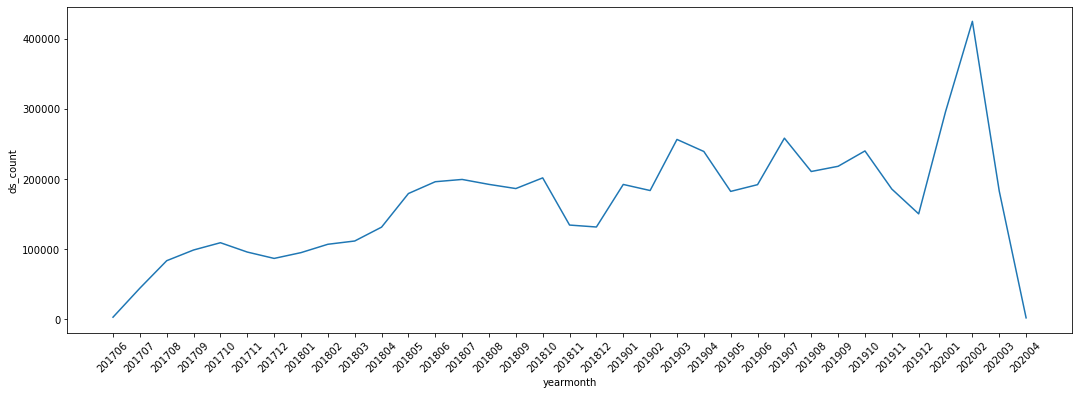

In [238]:
f = plt.figure(figsize=(18, 6))
ax = sns.lineplot(x="yearmonth", y="ds_count",
                  data=df_counts)
plt.xticks(rotation=45);

----

### Age and Gender Trips distribution

In [239]:
%%time
# Consider including AND member_gender IN ('Male', 'Female') or AND member_gender IS NOT NULL
query = '''SELECT age_group, IFNULL(member_gender, 'Unknown') member_gender, SUM(reccount) AS ds_count 
           FROM tripdata_fixed
           WHERE age_group IS NOT NULL
           GROUP BY age_group, member_gender ORDER BY 1, 2'''
df_age_gender = load_from_sql(query)

Wall time: 10.9 s


In [240]:
df_age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age_group      30 non-null     object
 1   member_gender  30 non-null     object
 2   ds_count       30 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 848.0+ bytes


In [241]:
df_age_gender.head()

,age_group,member_gender,ds_count
0,18-25,Female,123663
1,18-25,Male,354689
2,18-25,Other,5952
3,25-30,Female,205270
4,25-30,Male,509230


In [242]:
df_age_gender.tail()

,age_group,member_gender,ds_count
25,60-70,Male,44941
26,60-70,Other,360
27,70+,Female,790
28,70+,Male,6316
29,70+,Other,165


In [243]:
age_bin_names = ["18-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-70","70+"]
age_classes = pd.api.types.CategoricalDtype(ordered = True, categories = age_bin_names)
df_age_gender["age_group"] = df_age_gender["age_group"].astype(age_classes)

In [244]:
# gender bins names based on quantities in each group rther than alphbetic (or any implied ranking)
gender_bin_names = ["Male", "Female", "Other"]
gender_classes = pd.api.types.CategoricalDtype(ordered = True, categories = gender_bin_names)
df_age_gender["member_gender"] = df_age_gender["member_gender"].astype(gender_classes)

In [245]:
df_age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age_group      30 non-null     category
 1   member_gender  30 non-null     category
 2   ds_count       30 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 932.0 bytes


#### Discard any data not wanted before constructing categoricals...
- This could be eliminated in the query...

In [246]:
df_age_gender_mf = df_age_gender.query("member_gender != 'Other'").copy()

In [247]:
gender_bin_names_mf = ["Male", "Female"]
gender_classes_mf = pd.api.types.CategoricalDtype(ordered = True, categories = gender_bin_names_mf)
df_age_gender_mf["member_gender"] = df_age_gender_mf["member_gender"].astype(gender_classes_mf)

In [248]:
df_age_gender_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 28
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age_group      20 non-null     category
 1   member_gender  20 non-null     category
 2   ds_count       20 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 1.5 KB


In [249]:
df_age_gender.head()

,age_group,member_gender,ds_count
0,18-25,Female,123663
1,18-25,Male,354689
2,18-25,Other,5952
3,25-30,Female,205270
4,25-30,Male,509230


In [250]:
df_age_gender_mf.head()

,age_group,member_gender,ds_count
0,18-25,Female,123663
1,18-25,Male,354689
3,25-30,Female,205270
4,25-30,Male,509230
6,30-35,Female,167982


G:\Anaconda3\envs\pytorch_1_4\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


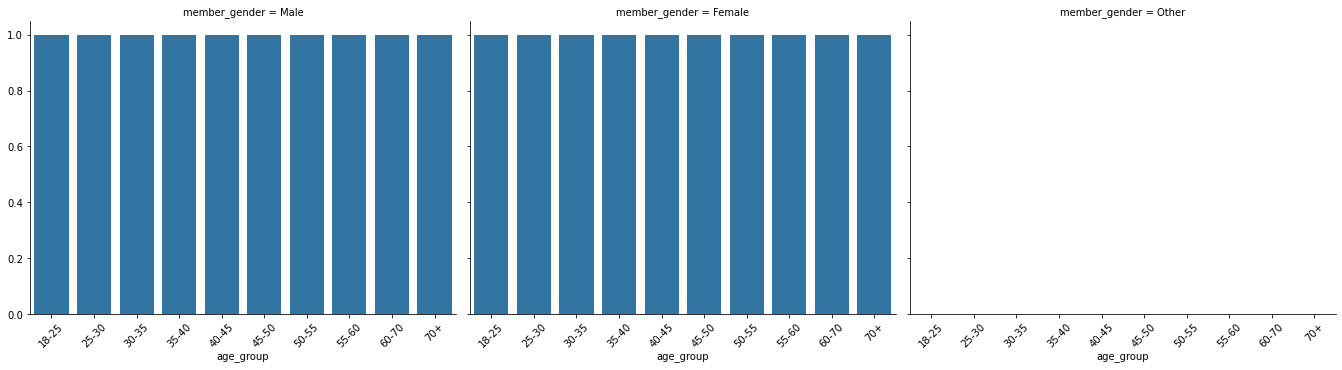

In [251]:
g = sns.FacetGrid(df_age_gender_mf, 
                  col="member_gender", height=5, aspect=1.25)
cht = g.map(sns.countplot, "age_group");
cht.set_xticklabels(rotation=45);

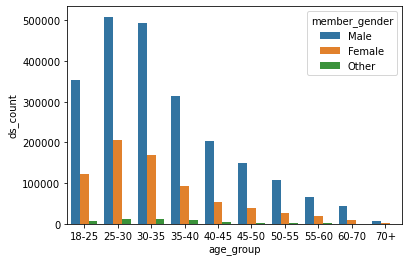

In [252]:
sns.barplot(x="age_group", y="ds_count", hue="member_gender", 
            data=df_age_gender);

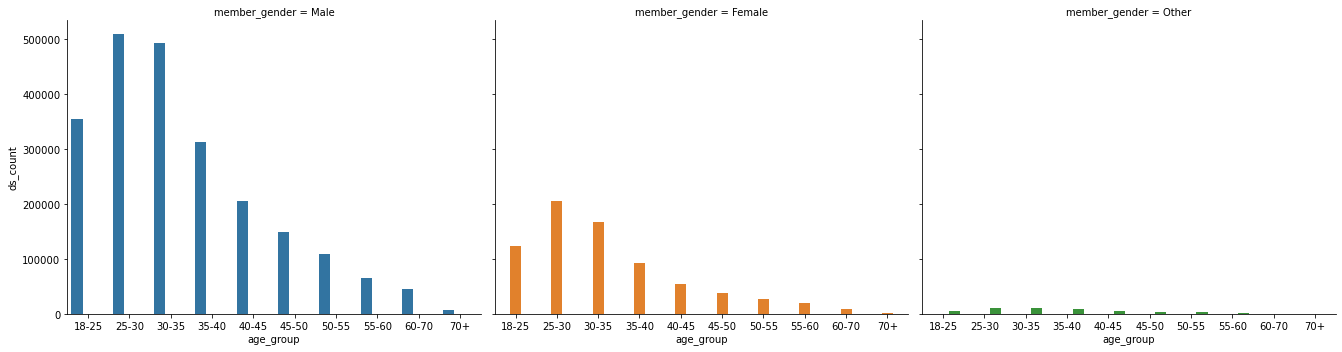

In [253]:
g = sns.catplot(x="age_group", y="ds_count",
                col="member_gender",             
                #color = base_color,
                hue="member_gender", 
                data=df_age_gender, 
                kind="bar",
                height=5, aspect=1.25);

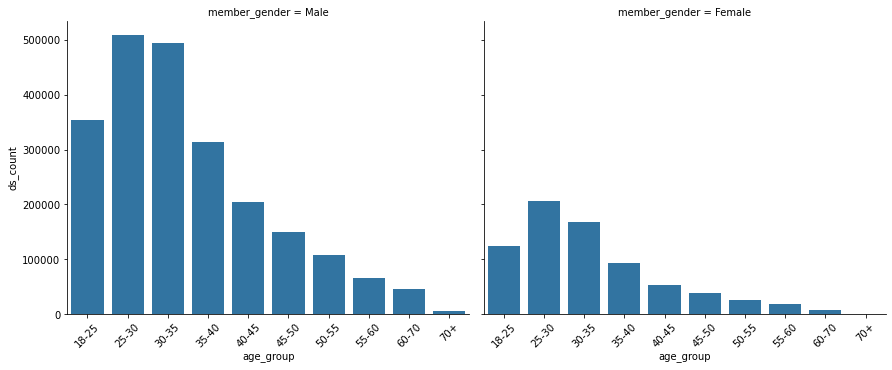

In [254]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="age_group", y="ds_count",
                col="member_gender",
                color = base_color,
                data=df_age_gender_mf, 
                kind="bar",
                height=5, aspect=1.25);
g.set_xticklabels(rotation=45);

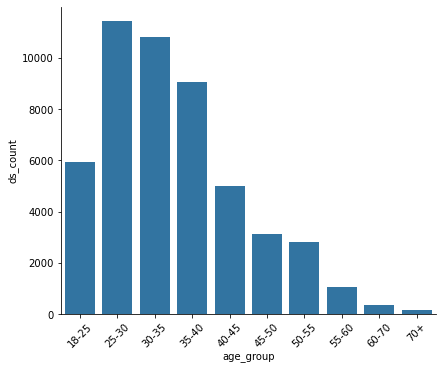

In [255]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="age_group", y="ds_count",
                color = base_color,
                data=df_age_gender.query("member_gender == 'Other'"), 
                kind="bar",
                height=5, aspect=1.25);
g.set_xticklabels(rotation=45);

In [256]:
%%time
query = '''SELECT age_group, member_gender, reccount
           FROM tripdata_fixed
           WHERE age_group IS NOT NULL AND member_gender IS NOT NULL'''
df_age_gender_detail = load_from_sql(query)

Wall time: 2min 9s


In [257]:
df_age_gender_detail["age_group"] = df_age_gender_detail["age_group"].astype(age_classes)

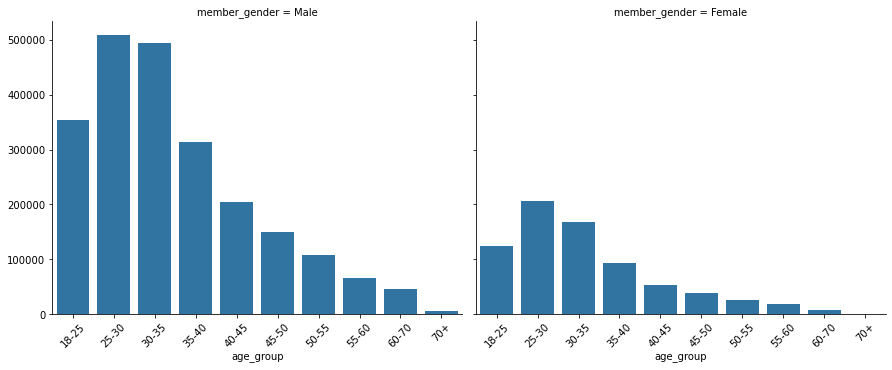

In [258]:
g = sns.FacetGrid(df_age_gender_detail.loc[df_age_gender_detail.member_gender != "Other"], 
                  col="member_gender", height=5, aspect=1.25)
cht = g.map(sns.countplot, "age_group");
cht.set_xticklabels(rotation=45);

# Data tidiness
This data is not tidy, as defined by the [rules of data tidiness](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html):
    
Tidy data is a standard way of mapping the meaning of a dataset to its structure.     
A dataset is messy or tidy depending on how rows, columns and tables are matched up with observations, variables and types. 
    
In tidy data:
    
- Each variable forms a column.
    
- Each observation forms a row.
    
- Each type of observational unit forms a table.
<br><br>

However, this data violates the rule that every type of observational unit should for its own table:
- Station latitude, longitude and name data are included in every row instead of being in a Station table
<br><br>
    
- However, regarding Station information:
    - Where station exists: latitude, longitude latitude and name may differ in different time periods
    - Where station does _not_ exist: latitude and longitude can differ per individual trip
    - Consequently, these measurements will need to be retained per individual trip
    - Also, when reporting on latitude and longitude it is likely that we will want to report trip frequencies
    - Therefore, it is easier to just retain the current format in the SQL backend



----
# Appendix

In [259]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>